In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import os
import numpy as np
import json
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import ast
import datetime as date

In [28]:
#Matplotlib defaults (eventually)
plt.rcParams.update({'font.size': 22})
plt.style.use("default")

# Step 1: Build data structures

See pg 116 in notebook

* Dataframe, organized by individual patent-author / patent-assignee combinations (with appropriate tags)
    - in Data/Patents/patent_MA_results.csv
* Dictionary linking patents to a list of cpds associated with it
    - in Data/Patents/patent_cpds_links.p
* Dictionary linking patents to a list of MA values associated with it
* Dictionary linking patents to classifications

In [3]:
## Patent/classification dictionary
author_df = pd.read_csv("Data/Patents/patent_author_records.csv")
assignee_df = pd.read_csv("Data/Patents/patent_assignee_records.csv")

In [4]:
#Do author/assignees have different patent ids?

author_ids = list(set(list(author_df["ID"])))
assignee_ids = list(set(list(assignee_df["ID"])))

print(len(author_ids))
print(len(assignee_ids))

print(len(set(author_ids) - set(assignee_ids))) #This should be 0...

744686
332467
660634


In [5]:
patent_classifications = dict(zip(author_df.ID, author_df.classification))

print(len(patent_classifications))

patent_classifications.update(dict(zip(assignee_df.ID, assignee_df.classification)))

print(len(patent_classifications))

# tqdm.pandas()

# print("----- Author Patents ----- ")
# for index, row in tqdm(author_df.iterrows(), total=len(author_df)):
#     patent_classifications[row["ID"]] = row["classification"]

# print("----- Assignee Patents -----")
# for index, row in tqdm(assignee_df.iterrows(), total=len(assignee_df)):
#     patent_classifications[row["ID"]] = row["classification"]



744686
993101


In [8]:
pickle.dump(patent_classifications, file=open("Data/Patents/patent_classification_links.p", "wb"))

# Step 2: Link MAs with authors/companies

(1/9) Currently incomplete - data is still running on agave

In [6]:
results_df = pd.read_csv("Data/Patents/patent_MA_results.csv")

print(results_df.head())

   Unnamed: 0                ID         author    assignees
0           0  US-2016000413-A1  A AMAR OUSAMA  UNIV_BOSTON
1           3  US-2016000413-A1   BIGIO IRVING  UNIV_BOSTON
2           6  US-2016000413-A1  BRIGGS JOHN C  UNIV_BOSTON
3           9  US-2016000413-A1  CHARGIN DAVID  UNIV_BOSTON
4          12  US-2016000413-A1  LEE STEPHANIE  UNIV_BOSTON


In [7]:
patent_cpd_links = pickle.load(file=open("Data/Patents/patent_cpd_links.p", "rb"))

In [5]:
print(list(patent_cpd_links.items())[0:5])

[('WO-2013069771-A1', ['SCHEMBL14948774', 'SCHEMBL14948814', 'SCHEMBL14948780', 'SCHEMBL14948825', 'SCHEMBL14948770', 'SCHEMBL14948779', 'SCHEMBL14948837', 'SCHEMBL14948833', 'SCHEMBL14948841', 'SCHEMBL14948781', 'SCHEMBL14948768', 'SCHEMBL14948832', 'SCHEMBL14948838', 'SCHEMBL14948773', 'SCHEMBL14948775', 'SCHEMBL14948777', 'SCHEMBL14948842', 'SCHEMBL14948776', 'SCHEMBL14948831', 'SCHEMBL14948824', 'SCHEMBL14948819', 'SCHEMBL14948828', 'SCHEMBL14948765', 'SCHEMBL14948767', 'SCHEMBL14948820', 'SCHEMBL14948827', 'SCHEMBL14948830', 'SCHEMBL14948766', 'SCHEMBL14948835', 'SCHEMBL14948839', 'SCHEMBL14948769', 'SCHEMBL14948826', 'SCHEMBL14948818', 'SCHEMBL14948843', 'SCHEMBL14948821', 'SCHEMBL14948772', 'SCHEMBL14948834', 'SCHEMBL14948778', 'SCHEMBL14948764', 'SCHEMBL14948771', 'SCHEMBL14948813', 'SCHEMBL14948836', 'SCHEMBL14948840', 'SCHEMBL14948822', 'SCHEMBL675', 'SCHEMBL14948829', 'SCHEMBL14948823']), ('US-5326574-A', ['SCHEMBL762', 'SCHEMBL762', 'SCHEMBL15065', 'SCHEMBL4591', 'SCHEMBL38

In [8]:
def get_MA(fp):
    """ Get AssemblyGo MA value

    Args:
        fp (str): filepath to a particular .txt AssemblyGo output file

    Returns:
        label (str): label of the compound which was analzyed (empty if a failure)
        MA (int): assemblyGo MA value (-1 if a failure)
    """
    with open(fp) as f:
        lines = f.readlines()

    try:
        #molfile will be the last element in 0th line
        label = lines[0].split()[-1].split("/")[-1].split(".")[0]

        #MA will be last elemnt in -2nd line (will be an int)
        MA = int(lines[-2].split()[-1])

        time = float(lines[-1].split()[-1])
        
        return label, MA, time

    except:
        return None, None, None

In [94]:
fp = "Data/AssemblyValues/AssigneeCpds_Done/"
MA_values = []
for file in tqdm(os.listdir(fp)):
    if file.endswith(".txt"):
        label, MA, time = get_MA(fp + file)
        MA_values.append({
            "label": label,
            "MA_assemblyGo": MA,
            "time": time
        })

MA_df = pd.DataFrame(MA_values)
MA_df.to_csv("Data/AssemblyValues/assigneeCpds_AssemblyGo.csv")

100%|██████████| 332246/332246 [02:17<00:00, 2417.94it/s]


In [9]:
#Link all cpds with MAs
MA_df = pd.read_csv("Data/AssemblyValues/assigneeCpds_AssemblyGo.csv")
cpd_MA_links = dict(zip(MA_df["label"], MA_df["MA_assemblyGo"]))
print(list(cpd_MA_links.items())[0:5])

[('SCHEMBL10000057', 10.0), ('SCHEMBL10000065', 8.0), ('SCHEMBL10000069', 12.0), ('SCHEMBL1000007', 19.0), ('SCHEMBL10000081', 16.0)]


In [10]:
def get_MA_values(ids, cpd_MA_links):
    """ Given a list of surechembl cpd ids, return a list of MA values associated with those ids

    Args:
        ids (list): list of all cpd ids
        cpd_MA_links (dict): id:MA dictionary

    Returns:
        list: list of all corresponding MA values
    """
    MAs = []
    for id in ids:
        try:
            MAs.append(cpd_MA_links[id])
        except KeyError:
            pass

    return MAs

In [11]:
patent_MA_links = {}

for patent, ids in tqdm(patent_cpd_links.items()):
    patent_MA_links[patent] = get_MA_values(ids, cpd_MA_links)

100%|██████████| 41940/41940 [00:03<00:00, 13787.53it/s]


In [9]:
print(list(patent_MA_links.items())[0:5])

[('WO-2013069771-A1', [22.0, 21.0, 14.0, 22.0, 10.0, 18.0, 11.0]), ('US-5326574-A', []), ('US-7687629-B2', []), ('US-6576689-B2', []), ('EP-1214363-B1', [])]


In [12]:
results_df["MAs"] = results_df["ID"].map(patent_MA_links)

In [14]:
print(results_df)

        Unnamed: 0                ID                author          assignees  \
0                0  US-2016000413-A1         A AMAR OUSAMA        UNIV_BOSTON   
1                3  US-2016000413-A1          BIGIO IRVING        UNIV_BOSTON   
2                6  US-2016000413-A1         BRIGGS JOHN C        UNIV_BOSTON   
3                9  US-2016000413-A1         CHARGIN DAVID        UNIV_BOSTON   
4               12  US-2016000413-A1         LEE STEPHANIE        UNIV_BOSTON   
...            ...               ...                   ...                ...   
373735      907679      US-5361239-A     ZOELLER WILLIAM A   BAKER_HUGHES_INC   
373736      907680  US-2021354847-A1        ZWEIG ANDREW M          BOEING_CO   
373737      907681     US-9751966-B2        ZWEIG ANDREW M          BOEING_CO   
373738      907682      US-4914171-A        ZWEIG ANDREW M  ALLIED_SIGNAL_INC   
373739      907683  US-2021009819-A1  ZWEIG ANDREW MICHAEL          BOEING_CO   

                           

In [13]:
## Add avg & max MA to results_df
MA_avgs = results_df.explode("MAs").groupby("ID").MAs.apply(np.mean)
MA_maxes = results_df.explode("MAs").groupby("ID").MAs.apply(max)
MA_avgs = dict(MA_avgs)
MA_maxes = dict(MA_maxes)

results_df["MA_avg"] = results_df["ID"].map(MA_avgs)
results_df["MA_max"] = results_df["ID"].map(MA_maxes)
print(results_df)

        Unnamed: 0                ID                author          assignees  \
0                0  US-2016000413-A1         A AMAR OUSAMA        UNIV_BOSTON   
1                3  US-2016000413-A1          BIGIO IRVING        UNIV_BOSTON   
2                6  US-2016000413-A1         BRIGGS JOHN C        UNIV_BOSTON   
3                9  US-2016000413-A1         CHARGIN DAVID        UNIV_BOSTON   
4               12  US-2016000413-A1         LEE STEPHANIE        UNIV_BOSTON   
...            ...               ...                   ...                ...   
373735      907679      US-5361239-A     ZOELLER WILLIAM A   BAKER_HUGHES_INC   
373736      907680  US-2021354847-A1        ZWEIG ANDREW M          BOEING_CO   
373737      907681     US-9751966-B2        ZWEIG ANDREW M          BOEING_CO   
373738      907682      US-4914171-A        ZWEIG ANDREW M  ALLIED_SIGNAL_INC   
373739      907683  US-2021009819-A1  ZWEIG ANDREW MICHAEL          BOEING_CO   

                           

In [14]:
#Drop all NaNs (testing for now)
results_df = results_df.dropna()
print(results_df)

        Unnamed: 0              ID             author  \
169            929   US-8440663-B2          AAY NAING   
170            947   US-8440663-B2      ARCALAS ARLYN   
171            965   US-8440663-B2      BROWN S DAVID   
172            983   US-8440663-B2  CHAN WAI KI VICKY   
173           1001   US-8440663-B2          CHEN JEFF   
...            ...             ...                ...   
373699      907631   US-8309497-B1         ZHANG YING   
373732      907673  US-10619065-B2     ZHOU ZHANG-LIN   
373733      907675  US-10619030-B2     ZHOU ZHANG-LIN   
373737      907681   US-9751966-B2     ZWEIG ANDREW M   
373738      907682    US-4914171-A     ZWEIG ANDREW M   

                             assignees  \
169                       EXELIXIS_INC   
170                       EXELIXIS_INC   
171                       EXELIXIS_INC   
172                       EXELIXIS_INC   
173                       EXELIXIS_INC   
...                                ...   
373699     HALLIBURTO

In [15]:
## Add classifications (in Data/Patents/patent_author_records.csv) to results dataframe

classification_df = pd.read_csv("Data/Patents/patent_author_records.csv")

In [16]:
results_df = results_df.merge(classification_df[["ID", "classification"]], on=["ID"], how="left")

results_df = results_df.loc[results_df.astype(str).drop_duplicates().index]

print(results_df)

         Unnamed: 0              ID             author  \
0               929   US-8440663-B2          AAY NAING   
486             947   US-8440663-B2      ARCALAS ARLYN   
972             965   US-8440663-B2      BROWN S DAVID   
1458            983   US-8440663-B2  CHAN WAI KI VICKY   
1944           1001   US-8440663-B2          CHEN JEFF   
...             ...             ...                ...   
1791610      907631   US-8309497-B1         ZHANG YING   
1791611      907673  US-10619065-B2     ZHOU ZHANG-LIN   
1791613      907675  US-10619030-B2     ZHOU ZHANG-LIN   
1791615      907681   US-9751966-B2     ZWEIG ANDREW M   
1791616      907682    US-4914171-A     ZWEIG ANDREW M   

                              assignees  \
0                          EXELIXIS_INC   
486                        EXELIXIS_INC   
972                        EXELIXIS_INC   
1458                       EXELIXIS_INC   
1944                       EXELIXIS_INC   
...                                 ...   
17

In [17]:
full_patent_dates = pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/CpdPatentIdsDates/Patent_Date_Dict/patent_date_dict_FULL.p", "rb"))

In [18]:
def get_date_fromDict(ID, full_patent_dates):
    return full_patent_dates[ID]

In [19]:
### Add dates to results dataframe
tqdm.pandas()

results_df["date"] = results_df["ID"].progress_apply(get_date_fromDict, args=(full_patent_dates, ))

100%|██████████| 60031/60031 [00:00<00:00, 352114.97it/s]


In [20]:
import datetime as dt

results_df["date"] = pd.to_datetime(results_df["date"])
results_df["date_ordinal"] = results_df["date"].map(dt.datetime.toordinal)

In [21]:
print(results_df)

         Unnamed: 0              ID             author  \
0               929   US-8440663-B2          AAY NAING   
486             947   US-8440663-B2      ARCALAS ARLYN   
972             965   US-8440663-B2      BROWN S DAVID   
1458            983   US-8440663-B2  CHAN WAI KI VICKY   
1944           1001   US-8440663-B2          CHEN JEFF   
...             ...             ...                ...   
1791610      907631   US-8309497-B1         ZHANG YING   
1791611      907673  US-10619065-B2     ZHOU ZHANG-LIN   
1791613      907675  US-10619030-B2     ZHOU ZHANG-LIN   
1791615      907681   US-9751966-B2     ZWEIG ANDREW M   
1791616      907682    US-4914171-A     ZWEIG ANDREW M   

                              assignees  \
0                          EXELIXIS_INC   
486                        EXELIXIS_INC   
972                        EXELIXIS_INC   
1458                       EXELIXIS_INC   
1944                       EXELIXIS_INC   
...                                 ...   
17

In [22]:
results_df.to_csv("Data/Patents/patent_MA_results_incomplete.csv")

In [102]:
testing_df = results_df[results_df["ID"].isin(["US-9751966-B2", "US-4914171-A"])]
print(testing_df)

         Unnamed: 0             ID          author          assignees  \
7443633      907681  US-9751966-B2  ZWEIG ANDREW M          BOEING_CO   
7443634      907682   US-4914171-A  ZWEIG ANDREW M  ALLIED_SIGNAL_INC   

                                               MAs  \
7443633  [9.0, 9.0, 8.0, 9.0, 8.0, 7.0, 9.0, 10.0]   
7443634                                 [9.0, 9.0]   

                                            classification  
7443633  ['C07C319/18', 'C07C323/12', 'C08F12/22', 'C08...  
7443634                          ['C08F20/30', 'C09D4/00']  


# Step 3: Statistics over MAs

Include dates, avg / max MA

In [69]:
# testing_df["MA_avg"] = testing_df.explode("MAs").groupby("ID").mean()
#print(testing_df.explode("MAs").groupby("ID").head())
print("-----")
MA_avgs = testing_df.explode("MAs").groupby("ID").MAs.apply(np.mean)
print(MA_avgs)
print(type(MA_avgs))
MA_avgs = dict(MA_avgs)
print(MA_avgs)

print(testing_df)

testing_df["MA_avg"] = testing_df["ID"].map(MA_avgs)
print(testing_df)

-----
ID
US-4914171-A     9.000
US-9751966-B2    8.625
Name: MAs, dtype: float64
<class 'pandas.core.series.Series'>
{'US-4914171-A': 9.0, 'US-9751966-B2': 8.625}
        Unnamed: 0             ID          author          assignees  \
373737      907681  US-9751966-B2  ZWEIG ANDREW M          BOEING_CO   
373738      907682   US-4914171-A  ZWEIG ANDREW M  ALLIED_SIGNAL_INC   

                                              MAs  MA_avg  
373737  [9.0, 9.0, 8.0, 9.0, 8.0, 7.0, 9.0, 10.0]     NaN  
373738                                 [9.0, 9.0]     NaN  
        Unnamed: 0             ID          author          assignees  \
373737      907681  US-9751966-B2  ZWEIG ANDREW M          BOEING_CO   
373738      907682   US-4914171-A  ZWEIG ANDREW M  ALLIED_SIGNAL_INC   

                                              MAs  MA_avg  
373737  [9.0, 9.0, 8.0, 9.0, 8.0, 7.0, 9.0, 10.0]   8.625  
373738                                 [9.0, 9.0]   9.000  


/var/folders/bx/hv1n_1yj6qv0z_5d3nqlhr5c0000gw/T/ipykernel_10710/3621337915.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df["MA_avg"] = testing_df["ID"].map(MA_avgs)


In [3]:
results_df = pd.read_csv("Data/Patents/patent_MA_results_incomplete.csv")

### Add dates to patent MAs

Use JSON files & priority dates (instead of filing date or publication date)

In [22]:
def get_date_fromJSON(ID):
    """ Find the priority date of a given patent

    Args:
        ID (str): patent ID

    Returns:
        str: priority date for a patent
    """
    fp = "Data/Patents/Patent_Records/patent_" + ID + ".json"

    try:
        data = json.load(open(fp))
    except FileNotFoundError as e:
        print(e)

    #Find specific priority date record
    headings = data["Record"]["Section"]
    for head in headings:
        if head["TOCHeading"] == "Important Dates":
            if head["Section"][0]["TOCHeading"] == "Priority Date":
                return head["Section"][0]["Information"][0]["Value"]["DateISO8601"][0]


In [23]:
def build_month_increments(start, stop):
    """ Build month increments in the form YYYY-MM

    Args:
        start (int): Starting year
        stop (int): Ending year

    Returns:
        list: list of strings in the form YYYY-MM (e.g., "1980-01")
    """
    months = []
    while start <= stop:
        for month in [
                "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
                "11", "12"
        ]:
            months.append(str(start) + "-" + month)
        start += 1

    return months

In [24]:
def get_date_fromDict(ID, full_patent_dates):
    return full_patent_dates[ID]

In [118]:
### Building full patent date dictionary - SHOULD ONLY BE RUN ONCE
full_patent_dates = {}
for month in tqdm(build_month_increments(1962,2020)):
    full_patent_dates.update(pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/CpdPatentIdsDates/Patent_Date_Dict/patent_date_dict_" + month + ".p", "rb")))

print(len(full_patent_dates))
pickle.dump(full_patent_dates, file=open("/Volumes/Macintosh HD 4/SureChemBL/CpdPatentIdsDates/Patent_Date_Dict/patent_date_dict_FULL.p", "wb"))

100%|██████████| 708/708 [00:05<00:00, 128.92it/s] 


4799617


## Isolate companies, find delta-MA over time

Starting full analysis - does the avg MA in companies change over time?

In [60]:
## Testing - start with a single company, get process down, then expand
sub_df = results_df[results_df["assignees"] == "EXELIXIS_INC"]

date_MA = dict(zip(sub_df.date, sub_df.MA_avg))
print(date_MA)

{Timestamp('2013-05-14 00:00:00'): 22.689034369885434, Timestamp('2011-09-06 00:00:00'): 22.848605577689238, Timestamp('2014-01-28 00:00:00'): 21.69230769230769, Timestamp('2012-12-04 00:00:00'): 16.952380952380953, Timestamp('2012-08-14 00:00:00'): 21.007220216606502, Timestamp('2011-12-13 00:00:00'): 21.004484304932735, Timestamp('2010-04-27 00:00:00'): 18.806122448979593, Timestamp('2014-02-11 00:00:00'): 23.12941176470588, Timestamp('2014-04-15 00:00:00'): 23.913461538461537, Timestamp('2014-02-04 00:00:00'): 17.847222222222218, Timestamp('2013-07-16 00:00:00'): 22.444444444444446, Timestamp('2011-10-25 00:00:00'): 14.31496062992126, Timestamp('2014-11-18 00:00:00'): 25.888349514563107, Timestamp('2020-07-30 00:00:00'): 22.8, Timestamp('2011-07-12 00:00:00'): 17.5625, Timestamp('2020-12-10 00:00:00'): 23.68354430379747, Timestamp('2018-07-31 00:00:00'): 21.357894736842105, Timestamp('2012-04-24 00:00:00'): 25.86450381679389, Timestamp('2011-05-31 00:00:00'): 15.983050847457626, Tim

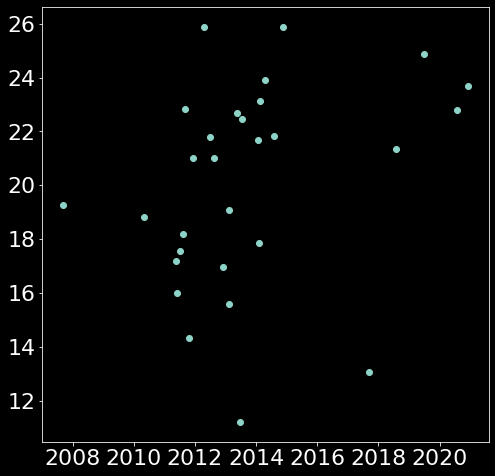

In [61]:
plt.figure(figsize=(8,8))

plt.scatter(date_MA.keys(), date_MA.values())

In [62]:
## Use sklearn to build linear regression model
linear_regressor = LinearRegression()
X = sub_df["date_ordinal"].values.reshape(-1,1)
Y = sub_df["MA_avg"].values.reshape(-1,1)
reg = linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

In [63]:
print(Y_pred[0])

[20.40954726]


In [35]:
print(min(Y_pred)[0])
print(max(Y_pred))

15.144754223755868
[15.42668028]


In [16]:
## Use statsmodels to find pvalue
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
coef = est2.summary2().tables[1]["Coef."]["x1"]
pvalue = est2.summary2().tables[1]["P>|t|"]["x1"]
r2 = list(est2.summary2().tables[0][1])[-1]
print(est2.summary())
print(coef)
print(pvalue)
print(r2)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     20.98
Date:                Tue, 24 Jan 2023   Prob (F-statistic):           6.27e-06
Time:                        15:16:43   Log-Likelihood:                -978.25
No. Observations:                 386   AIC:                             1961.
Df Residuals:                     384   BIC:                             1968.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -635.6409    143.194     -4.439      0.0

In [40]:
print("R2:", reg.score(X, Y))
print("Coefficient:", reg.coef_[0][0])
print("Intercept:", reg.intercept_)

R2: 0.0004039271830599267
Coefficient: -4.339994658170755e-05
Intercept: [46.81169885]


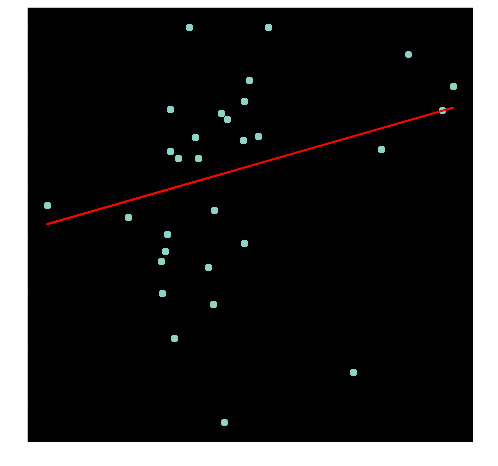

In [18]:
plt.figure(figsize=(8,8))

plt.scatter(X, Y)
plt.plot(X, Y_pred, color="red")

### Full analysis

Goal - plot regressions for 100 companies on a single graph

100%|██████████| 28069/28069 [02:48<00:00, 166.56it/s]


Text(0, 0.5, 'Average MA')

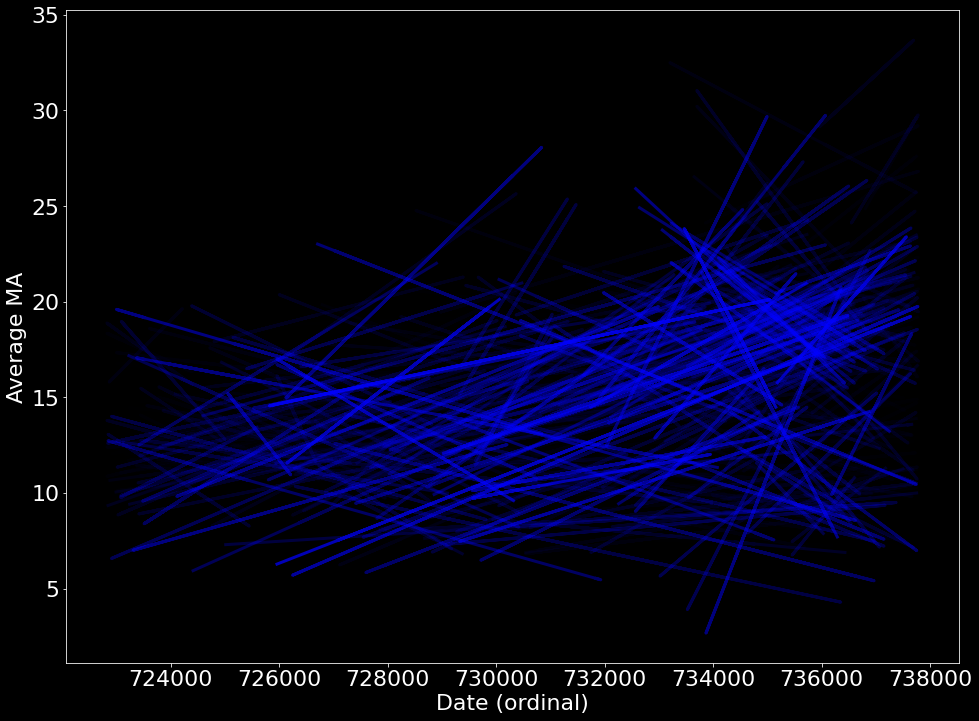

In [51]:
plt.figure(figsize=(16,12))

linear_regressor = LinearRegression()



author_sizes = []
author_rsqs = []
author_deltaMAs = []
author_slopes = []


for author in tqdm(list(results_df["author"].unique())):
    sub_df = results_df[results_df["author"] == author]
    if len(sub_df) > 10:

        author_sizes.append(len(sub_df))
    
        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            #Store slope
            author_slopes.append(reg.coef_[0][0])

            #Calculate deltaMA (change in MA of linear regression)
            author_deltaMAs.append(max(Y_pred)[0] - min(Y_pred)[0])

            # #Find r2, use that as alpha (just as a test)
            # X2 = sm.add_constant(X)
            # est = sm.OLS(Y, X2)
            # est2 = est.fit()
            
            # r2 = list(est2.summary2().tables[0][1])[-1]
            r2 = reg.score(X, Y)
            
            author_rsqs.append(r2)

            plt.plot(X, Y_pred, linewidth=3, alpha=float(r2), color="blue")
        except ValueError as e:
            pass

# plt.legend()
plt.xlabel("Date (ordinal)")
plt.ylabel("Average MA")

# plt.savefig("assignee_author_linear_regressions.png", format="png")


100%|██████████| 28069/28069 [02:51<00:00, 163.95it/s]


Text(0, 0.5, 'Max MA')

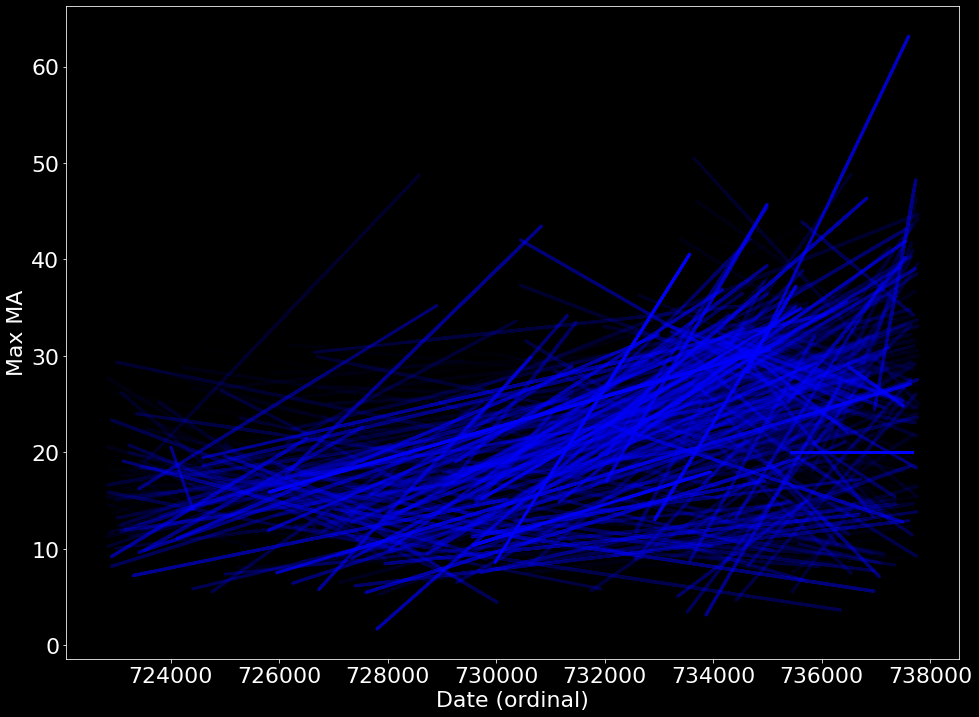

In [48]:
plt.figure(figsize=(16,12))

linear_regressor = LinearRegression()



author_sizes = []
author_rsqs = []
author_deltaMAs = []
author_slopes = []


for author in tqdm(list(results_df["author"].unique())):
    sub_df = results_df[results_df["author"] == author]
    if len(sub_df) >= 10:

        author_sizes.append(len(sub_df))

    
        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_max"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            #Store slope
            author_slopes.append(reg.coef_[0][0])

            #Calculate deltaMA (change in MA of linear regression)
            author_deltaMAs.append(max(Y_pred)[0] - min(Y_pred)[0])

            # #Find r2, use that as alpha (just as a test)
            # X2 = sm.add_constant(X)
            # est = sm.OLS(Y, X2)
            # est2 = est.fit()
            
            # r2 = list(est2.summary2().tables[0][1])[-1]
            r2 = reg.score(X, Y)
            
            author_rsqs.append(r2)

            plt.plot(X, Y_pred, linewidth=3, alpha=float(r2), color="blue")
        except ValueError as e:
            pass

# plt.legend()
plt.xlabel("Date (ordinal)")
plt.ylabel("Max MA")

# plt.savefig("assignee_author_linear_regressions.png", format="png")


100%|██████████| 539/539 [00:05<00:00, 97.01it/s] 


Text(0, 0.5, 'Average MA')

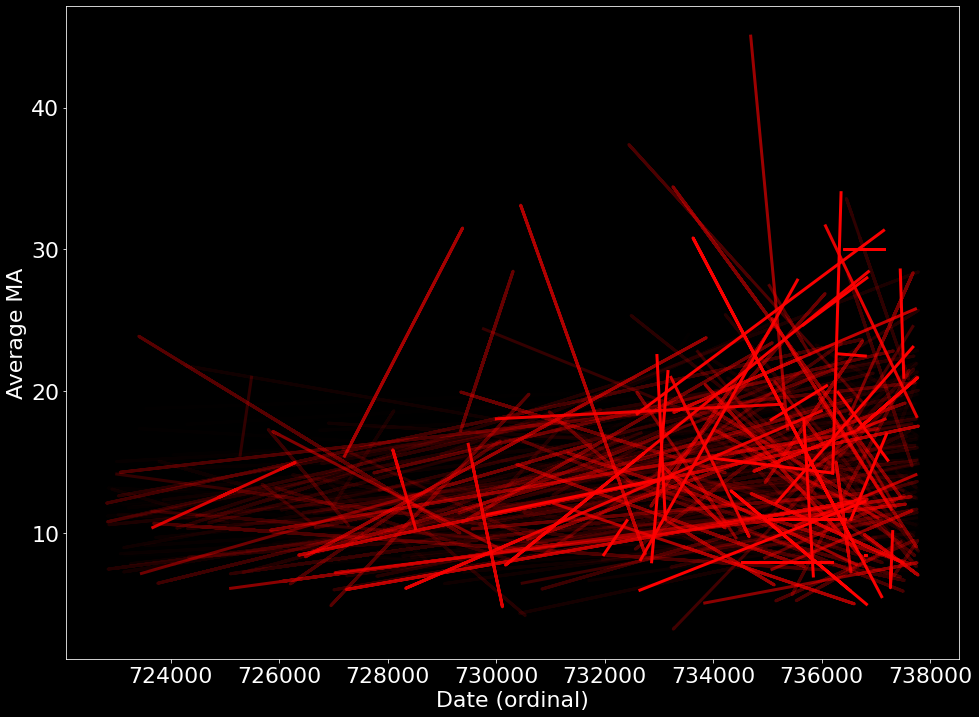

In [14]:
plt.figure(figsize=(16,12))

linear_regressor = LinearRegression()

assignee_sizes = []
assignee_rsqs = []
assignee_deltaMAs = []
assignee_slopes = []

for assignee in tqdm(list(results_df["assignees"].unique())):
    sub_df = results_df[results_df["assignees"] == assignee]

    if len(sub_df) > 10:
        
        assignee_sizes.append(len(sub_df))

    
        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            #Store slope
            assignee_slopes.append(reg.coef_[0][0])

            #Calculate deltaMA (change in MA of linear regression)
            assignee_deltaMAs.append(max(Y_pred)[0] - min(Y_pred)[0])

            #Find r2, use that as alpha (just as a test)
            X2 = sm.add_constant(X)
            est = sm.OLS(Y, X2)
            est2 = est.fit()
            
            r2 = reg.score(X, Y)
            assignee_rsqs.append(r2)

            plt.plot(X, Y_pred, linewidth=3, alpha=float(r2), color="red")
        except ValueError as e:
            pass



# plt.legend()
plt.xlabel("Date (ordinal)")
plt.ylabel("Average MA")

100%|██████████| 539/539 [00:04<00:00, 118.03it/s]


Text(0, 0.5, 'Max MA')

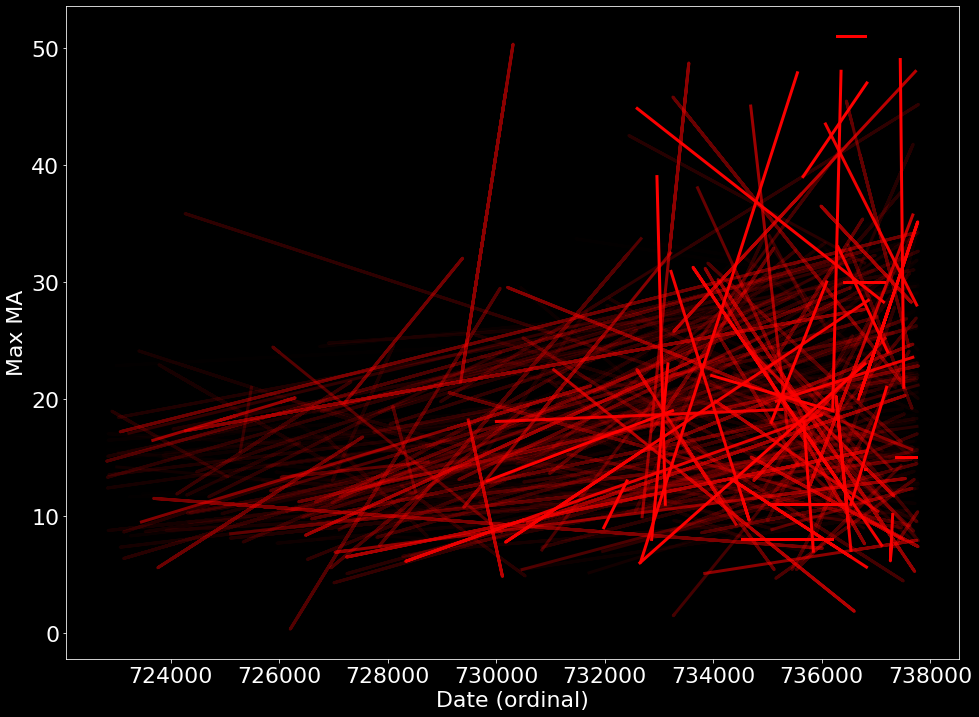

In [39]:
plt.figure(figsize=(16,12))

linear_regressor = LinearRegression()

assignee_sizes = []
assignee_rsqs = []
assignee_deltaMAs = []
assignee_slopes = []

for assignee in tqdm(list(results_df["assignees"].unique())):
    sub_df = results_df[results_df["assignees"] == assignee]

    if len(sub_df) > 10:
    
        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_max"].values.reshape(-1,1)
        try:

            assignee_sizes.append(len(sub_df))
            
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            #Store slope
            assignee_slopes.append(reg.coef_[0][0])

            #Calculate deltaMA (change in MA of linear regression)
            assignee_deltaMAs.append(max(Y_pred)[0] - min(Y_pred)[0])

            #Find r2, use that as alpha (just as a test)
            X2 = sm.add_constant(X)
            est = sm.OLS(Y, X2)
            est2 = est.fit()
            
            r2 = reg.score(X, Y)
            assignee_rsqs.append(r2)

            plt.plot(X, Y_pred, linewidth=3, alpha=float(r2), color="red")
        except ValueError as e:
            pass



# plt.legend()
plt.xlabel("Date (ordinal)")
plt.ylabel("Max MA")

In [52]:
### Filter out r2s with >0.25 correlation

# Starting out with authors
correlation_loc = np.where(np.asarray(author_rsqs) >= 0.25)
print(correlation_loc)

author_deltaMAs_sig = [author_deltaMAs[i] for i in correlation_loc[0]]
author_slopes_sig = [author_slopes[i] for i in correlation_loc[0]]
author_rsqs_sig = [author_rsqs[i] for i in correlation_loc[0]]
author_sizes_sig = [author_sizes[i] for i in correlation_loc[0]]

print("Number of highly correlated values:", len(correlation_loc[0]))
print("Number of authors:", len(author_rsqs))


(array([  2,  10,  11,  17,  25,  32,  36,  41,  45,  53,  67,  68,  74,
        79,  84,  85,  87,  90,  92,  95,  98, 100, 112, 114, 119, 121,
       123, 126, 137, 143, 149, 150, 151, 153, 154, 159, 162, 168, 173,
       176, 179, 185, 187, 188, 190, 197, 198, 204, 211, 228, 229, 242,
       243, 245, 246, 247, 250, 283, 287, 288, 289, 295, 296, 306, 314,
       316, 318, 328, 329, 332, 335, 338, 339, 341, 342, 344, 347, 348,
       350, 351, 353, 356, 365, 383, 385, 386, 387, 393, 400, 404, 412,
       419, 421, 440, 441, 453, 454, 456, 461, 467, 478, 479, 480, 487,
       497, 505]),)
Number of highly correlated values: 106
Number of authors: 509


Text(0.5, 0.98, 'Author Correlations - Average MA, r2 >= 0.25')

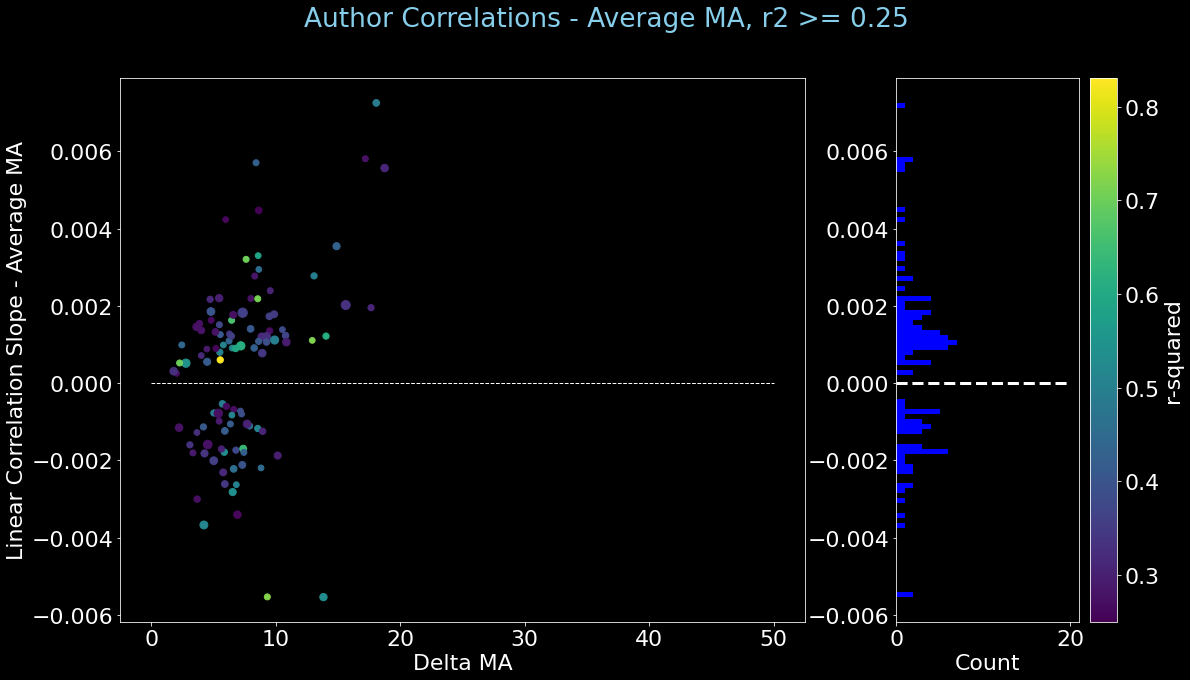

In [53]:
## Plot deltaMA / slope correlation (does deltaMA correspond with the slope at all? This is the big one...)
import matplotlib.colors as Color

#Authors first
fig, axes = plt.subplots(1,2, figsize=(18,10), gridspec_kw={"width_ratios":[3,1]})

scatter = axes[0].scatter(author_deltaMAs_sig, author_slopes_sig, c = author_rsqs_sig, s=np.array(author_sizes_sig)*3, cmap="viridis")
axes[0].hlines(xmin=0,xmax=50, y=0, color="white", linewidth=1, linestyle="--")
axes[0].set_xlabel("Delta MA")
axes[0].set_ylabel("Linear Correlation Slope - Average MA")

axes[1].hist(author_slopes_sig, bins=100, color="blue", orientation="horizontal")
axes[1].hlines(xmin=0,xmax=20, y=0, color="white", linewidth=3, linestyle="--")
axes[1].set_xlabel("Count")


plt.colorbar(scatter, label="r-squared", ax=axes[1])

plt.suptitle("Author Correlations - Average MA, r2 >= 0.25", color="skyblue")


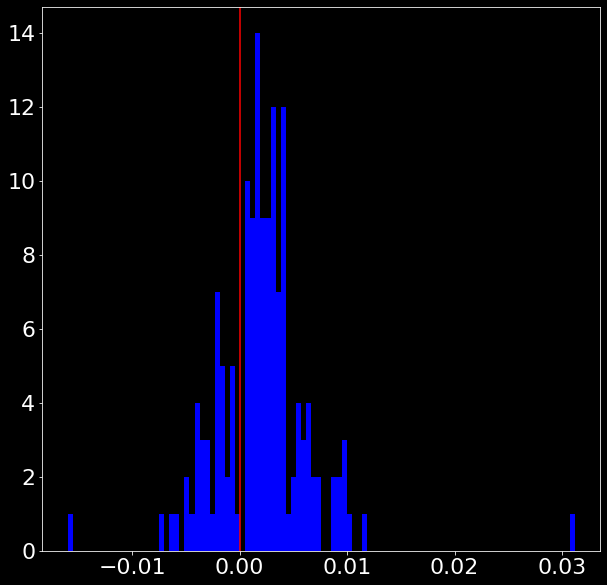

In [31]:
plt.figure(figsize=(10,10))

#Histogram of the number of various slopes
plt.hist(author_slopes_sig, color="blue", bins=100)

plt.axvline(0, color="red")

plt.show()

In [32]:
stats.skew(author_slopes_sig)

1.340993259882612

100%|██████████| 28069/28069 [18:19<00:00, 25.54it/s]


Text(0, 0.5, 'Count')

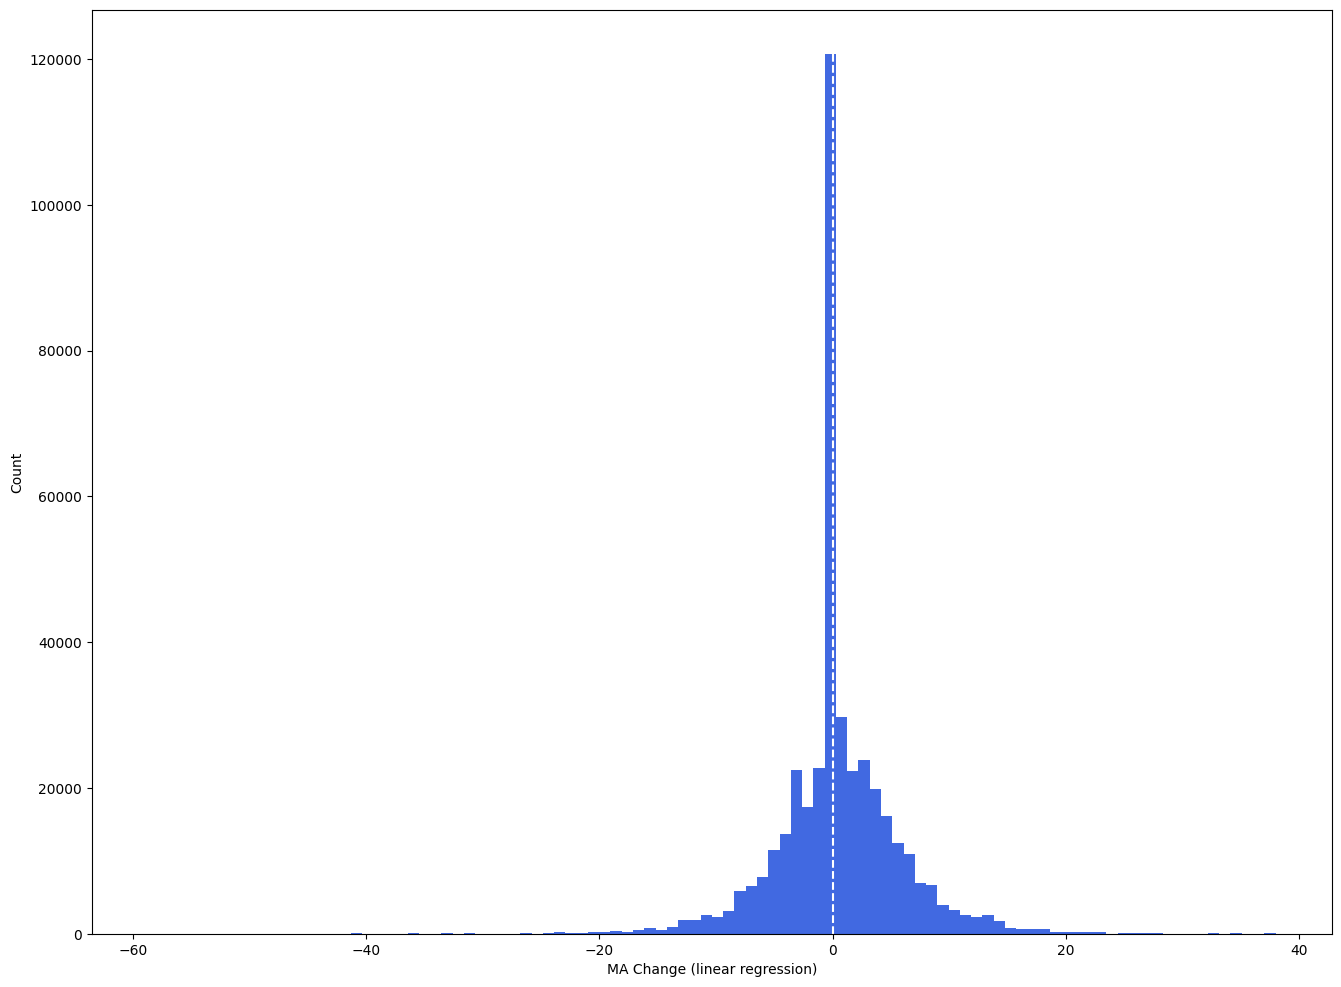

In [38]:
#Alternative graphing (finding slope change in MA)
linear_regressor = LinearRegression()

MA_slopes = []

for author in tqdm(list(results_df["author"].unique())):
    sub_df = results_df[results_df["author"] == author]
    if len(sub_df) > 10:

        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            #Calculate deltaMA (change in MA of linear regression, taking into consideration negative slopes)
            MA_slopes.extend([reg.coef_[0][0] * (max(X) - min(X))[0]] * len(sub_df))
                        
        except ValueError as e:
            pass

plt.figure(figsize=(16,12))


plt.hist(MA_slopes, bins=100, color="royalblue")
plt.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--")
plt.xlabel("MA Change (linear regression)")
plt.ylabel("Count")
# plt.title("Average MA changes - Authors", color="skyblue")


In [41]:
# Now assignees
correlation_loc = np.where(np.asarray(assignee_rsqs) >= 0.25)
print(correlation_loc)

assignee_deltaMAs_sig = [assignee_deltaMAs[i] for i in correlation_loc[0]]
assignee_slopes_sig = [assignee_slopes[i] for i in correlation_loc[0]]
assignee_rsqs_sig = [assignee_rsqs[i] for i in correlation_loc[0]]
assignee_sizes_sig = [assignee_sizes[i] for i in correlation_loc[0]]

print("Number of highly correlated values:", len(correlation_loc[0]))
print("Number of assignees:", len(assignee_rsqs))

(array([  3,   5,  10,  38,  49,  68,  72,  76,  78,  82,  85,  86,  89,
        91, 109, 123, 127, 130, 144, 145, 148, 155, 158, 163, 168, 170,
       174, 177, 180, 185, 193, 197, 199, 200, 209, 218, 222, 226, 227,
       228, 230, 235, 238, 240, 246, 247, 252, 257, 258, 265, 272, 274,
       276, 277, 278, 281, 290, 292, 296, 299, 300, 306, 311, 313, 314,
       316, 326, 327, 329, 331, 332, 333, 335, 336, 342, 343, 347, 348,
       349, 354, 355, 356, 357, 358, 359, 360, 361, 366, 368, 370, 371,
       374, 375, 376, 378, 380, 381, 382, 383, 385, 388, 390, 391]),)
Number of highly correlated values: 103
Number of assignees: 392


Text(0.5, 0.98, 'Assignee Correlations - Max MA, r2 >= 0.25')

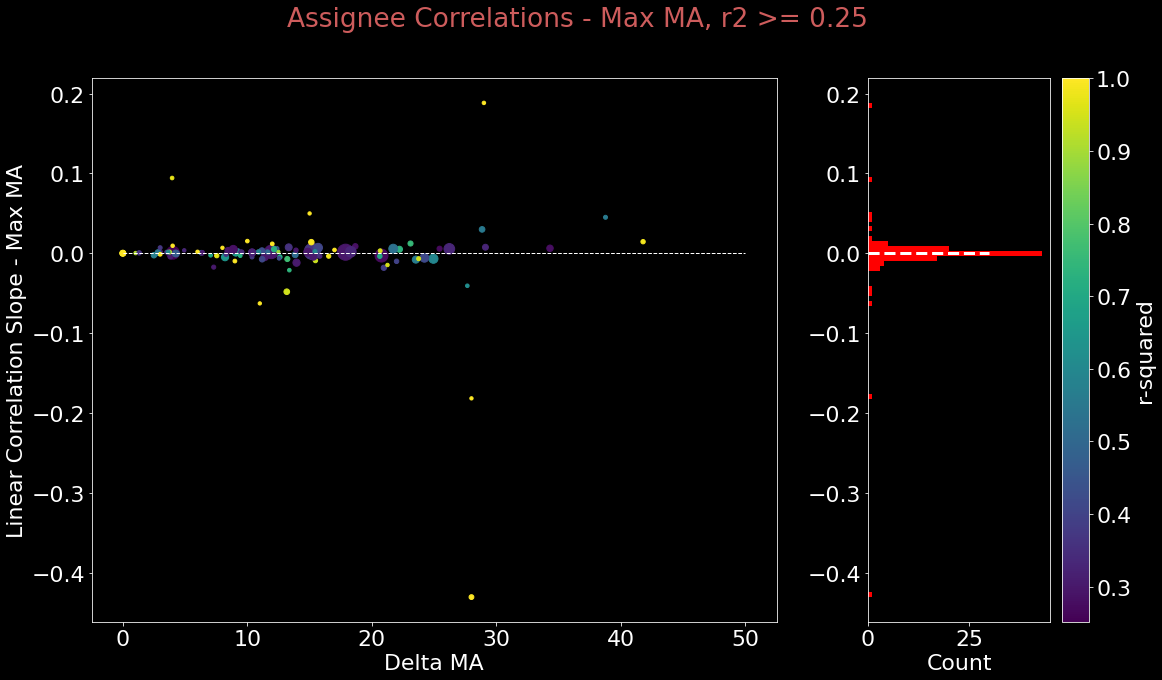

In [42]:
## Plot deltaMA / slope correlation 

#Authors first
fig, axes = plt.subplots(1,2, figsize=(18,10), gridspec_kw={"width_ratios":[3,1]})

scatter = axes[0].scatter(assignee_deltaMAs_sig, assignee_slopes_sig, c = assignee_rsqs_sig, s=np.array(assignee_sizes_sig), cmap="viridis")
axes[0].hlines(xmin=0,xmax=50, y=0, color="white", linewidth=1, linestyle="--")
axes[0].set_xlabel("Delta MA")
axes[0].set_ylabel("Linear Correlation Slope - Max MA")

axes[1].hist(assignee_slopes_sig, bins=100, color="red", orientation="horizontal")
axes[1].hlines(xmin=0,xmax=30, y=0, color="white", linewidth=3, linestyle="--")
axes[1].set_xlabel("Count")

plt.colorbar(scatter, label="r-squared", ax=axes[1])

plt.suptitle("Assignee Correlations - Max MA, r2 >= 0.25", color="indianred")


In [145]:
stats.skew(assignee_slopes)

-10.286362937887933

100%|██████████| 539/539 [00:03<00:00, 149.11it/s]


Text(0, 0.5, 'Patents')

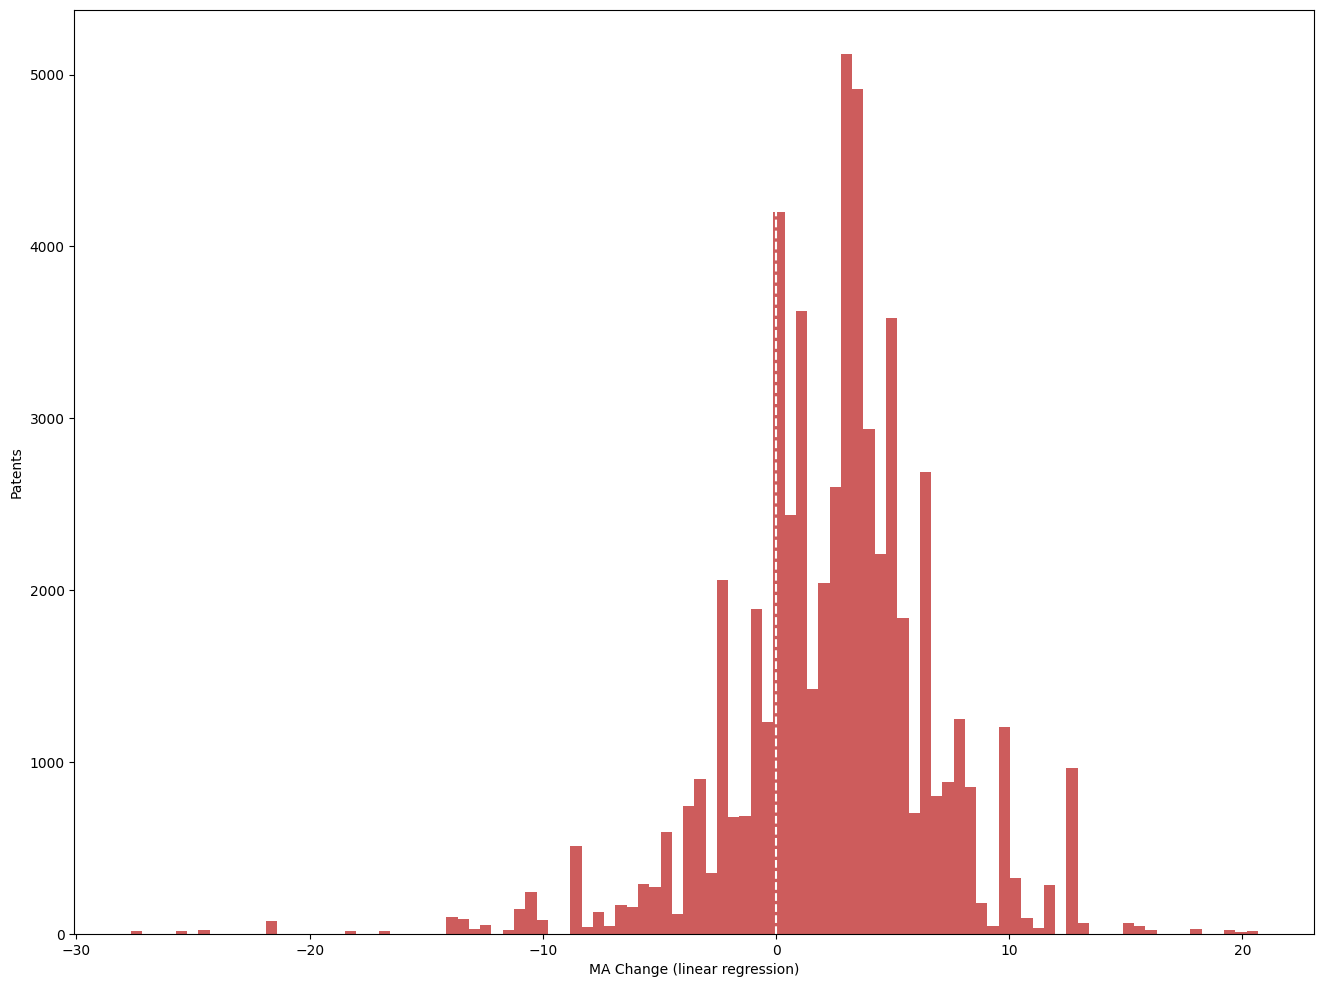

In [29]:
#Alternative graphing (finding slope change in MA)
linear_regressor = LinearRegression()

MA_slopes = []
counts = []

for assignee in tqdm(list(results_df["assignees"].unique())):
    sub_df = results_df[results_df["assignees"] == assignee]
    if len(sub_df) > 10:

        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            #Calculate deltaMA (change in MA of linear regression, taking into consideration negative slopes)
            MA_slopes.extend([reg.coef_[0][0] * (max(X) - min(X))[0]]*len(sub_df))
                        
        except ValueError as e:
            pass

plt.figure(figsize=(16,12))


plt.hist(MA_slopes, bins=100, histtype="bar", color="indianred")
plt.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--")
plt.xlabel("MA Change (linear regression)")
plt.ylabel("Patents")
# plt.title("Average MA changes - Assignees", color="indianred")


100%|██████████| 539/539 [00:03<00:00, 163.82it/s]


84
['UNIV_MICHIGAN_REGENTS', 'UNIV_HOKKAIDO_NAT_UNIV_CORP', 'UNIV_NEW_YORK', 'UNIV_NEW_YORK_STATE_RES_FOUND', 'UNIV_TOKYO', 'UNIV_CHICAGO', 'UNIV_VIRGINIA', 'UNIV_PUTRA_MALAYSIA', 'UNIV_WASHINGTON', 'UNIV_BIRMINGHAM', 'UNIV_KINGSTON', 'UNIV_OHIO_STATE_RES_FOUND', 'UNIV_VANDERBILT', 'UNIV_COLORADO', 'UNIV_COLORADO_REGENTS', 'UNIV_DREXEL', 'SEOUL_NAT_UNIV_IND_FOUNDATION', 'UNIV_TENNESSEE_RES_FOUNDATION', 'UNIV_CASE_WESTERN_RESERVE', 'UNIV_MONTPELLIER', 'UNIV_MONTPELLIER_II', 'UNIV_PARIS_CURIE', 'UNIV_BRITISH_COLUMBIA', 'UNIV_GENT', 'UNIV_MINAS_GERAIS', 'UNIV_WOLLONGONG', 'UNIVERSITY_PATENTS_INC', 'UNIV_CORNELL', 'UNIV_MARYLAND', 'UNIV_NANYANG_TECH', 'UNIV_UTAH_RES_FOUND', 'UNIV_EWHA_IND_COLLABORATION', 'UNIV_ROCHESTER', 'UNIV_KENTUCKY_RES', 'UNIV_KENTUCKY_RES_FOUND', 'UNIV_CONNECTICUT', 'UNIV_MICHIGAN_STATE', 'UNIV_LELAND_STANFORD_JUNIOR', 'UNIV_DUKE', 'UNIV_OXFORD_INNOVATION_LTD', 'UNIV_ST_ANDREWS', 'UNIV_KYOTO', 'UNIV_CHIBA_NAT_UNIV_CORP', 'RAMOT_AT_TEL-AVIV_UNIV_LTD', 'UNIV_CARNEGIE_M

Text(0.5, 1.0, 'Average MA changes - University Assignees')

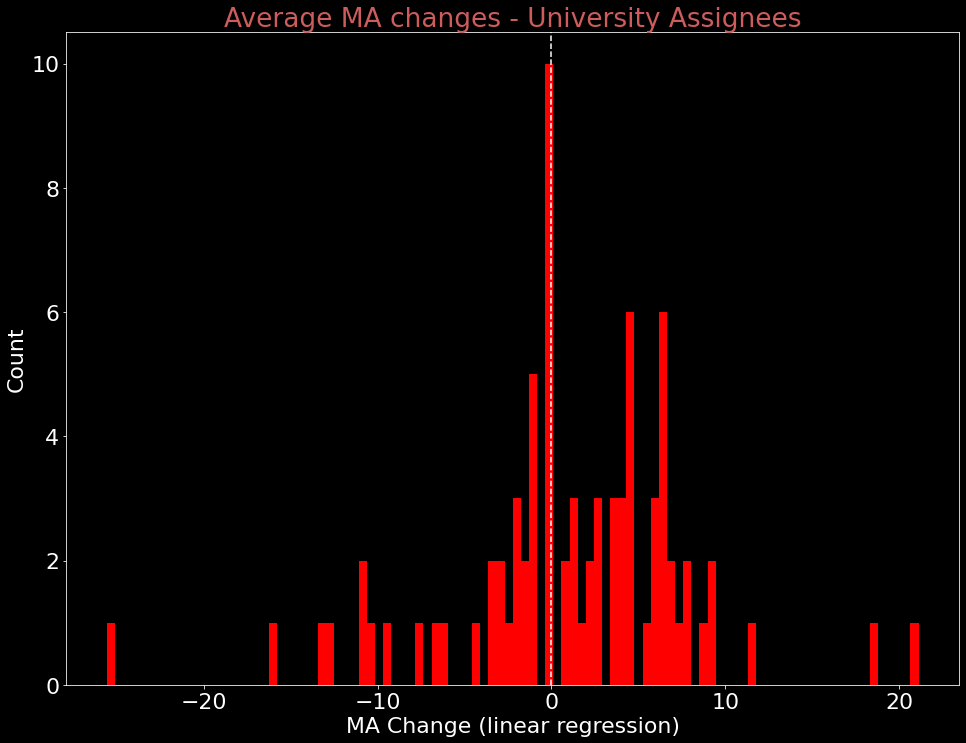

In [71]:
#Alternative graphing (finding slope change in MA)
linear_regressor = LinearRegression()

MA_slopes = []
universities = []

for assignee in tqdm(list(results_df["assignees"].unique())):
    if "UNIV" in assignee:
        universities.append(assignee)

        sub_df = results_df[results_df["assignees"] == assignee]
        if len(sub_df) > 10:

            X = sub_df["date_ordinal"].values.reshape(-1,1)
            Y = sub_df["MA_avg"].values.reshape(-1,1)
            try:
                reg = linear_regressor.fit(X, Y)
                Y_pred = linear_regressor.predict(X)

                #Calculate deltaMA (change in MA of linear regression, taking into consideration negative slopes)
                MA_slopes.append(reg.coef_[0][0] * (max(X) - min(X))[0])
                            
            except ValueError as e:
                pass
    else:
        pass


print(len(universities))
print(universities)


plt.figure(figsize=(16,12))


plt.hist(MA_slopes, bins=100, color="red")
plt.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--")
plt.xlabel("MA Change (linear regression)")
plt.ylabel("Count")
plt.title("Average MA changes - University Assignees", color="indianred")


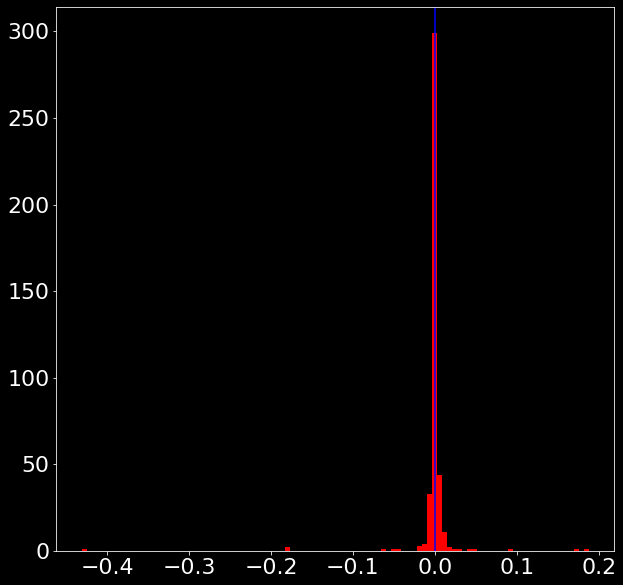

In [129]:
plt.figure(figsize=(10,10))

#Histogram of the number of various slopes
plt.hist(assignee_slopes, color="red", bins=100)

plt.axvline(0, color="blue")

plt.show()

Text(0, 0.5, 'r2 values')

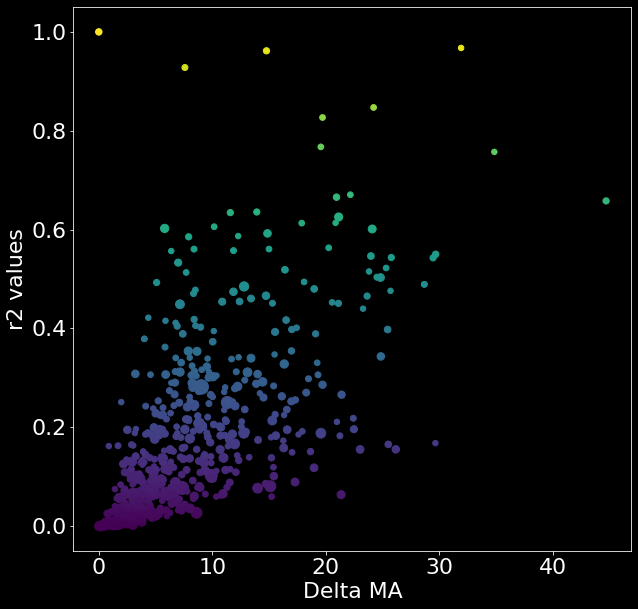

In [141]:
##Plot deltaMA / r2 correlation (does delta MA correspond with significance in any way?)

#Authors first
plt.figure(figsize=(10,10))

plt.scatter(author_deltaMAs, author_rsqs, c = author_rsqs, s=np.array(author_sizes)*3, cmap="viridis")

plt.xlabel("Delta MA")
plt.ylabel("r2 values")


Text(0, 0.5, 'r2 values')

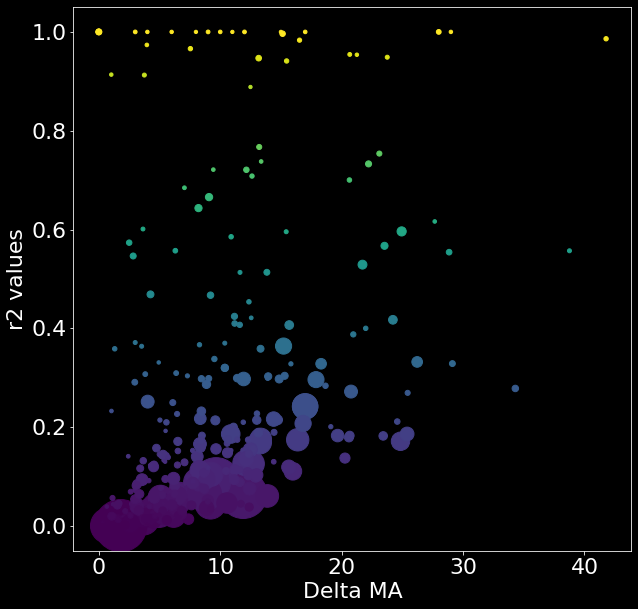

In [142]:
#Now assignees
plt.figure(figsize=(10,10))

plt.scatter(assignee_deltaMAs, assignee_rsqs, c = assignee_rsqs, s=np.array(assignee_sizes), cmap="viridis")

plt.xlabel("Delta MA")
plt.ylabel("r2 values")

In [80]:
#Average size of patents
print(np.mean(assignee_sizes))
print(np.mean(author_sizes))

111.3747680890538
2.1386939328084362


In [82]:
print(len(author_patents))
print(len(assignee_patents))

28069
539


## Classifcation MA Increase

Do classifications have any impact on MA? And/or do specific classifications have a high impact on MA?

In [31]:
def classification_to_list(classification):
    try:
        return ast.literal_eval(classification)
    except ValueError:
        return []
    except SyntaxError:
        return classification.strip('][').split(',')

In [32]:
tqdm.pandas()

results_df["classification"] = results_df["classification"].progress_apply(classification_to_list)

100%|██████████| 60031/60031 [00:02<00:00, 20186.90it/s]


In [33]:
#Explode classifications
results_df = results_df.explode("classification")


In [34]:
## Remove backslash and two numbers after it (and put them in a different column, in case they are useful later...)
def filter_classification(classification):
    try:
        return classification.split("/")[0]
    except AttributeError:
        return ""

In [35]:
tqdm.pandas()

results_df["filtered_classification"] = results_df["classification"].progress_apply(filter_classification)

print(results_df)

100%|██████████| 498189/498189 [00:01<00:00, 386960.28it/s]


         Unnamed: 0             ID          author          assignees  \
0               929  US-8440663-B2       AAY NAING       EXELIXIS_INC   
0               929  US-8440663-B2       AAY NAING       EXELIXIS_INC   
0               929  US-8440663-B2       AAY NAING       EXELIXIS_INC   
0               929  US-8440663-B2       AAY NAING       EXELIXIS_INC   
486             947  US-8440663-B2   ARCALAS ARLYN       EXELIXIS_INC   
...             ...            ...             ...                ...   
1791615      907681  US-9751966-B2  ZWEIG ANDREW M          BOEING_CO   
1791615      907681  US-9751966-B2  ZWEIG ANDREW M          BOEING_CO   
1791615      907681  US-9751966-B2  ZWEIG ANDREW M          BOEING_CO   
1791616      907682   US-4914171-A  ZWEIG ANDREW M  ALLIED_SIGNAL_INC   
1791616      907682   US-4914171-A  ZWEIG ANDREW M  ALLIED_SIGNAL_INC   

                                                       MAs     MA_avg  MA_max  \
0        [19.0, 22.0, 19.0, 26.0, 19.0, 26

### Standard MA analysis from here

Final data analysis will be digging into what classifications (if any) are interesting

100%|██████████| 1582/1582 [01:09<00:00, 22.84it/s]


Text(0, 0.5, 'Average MA')

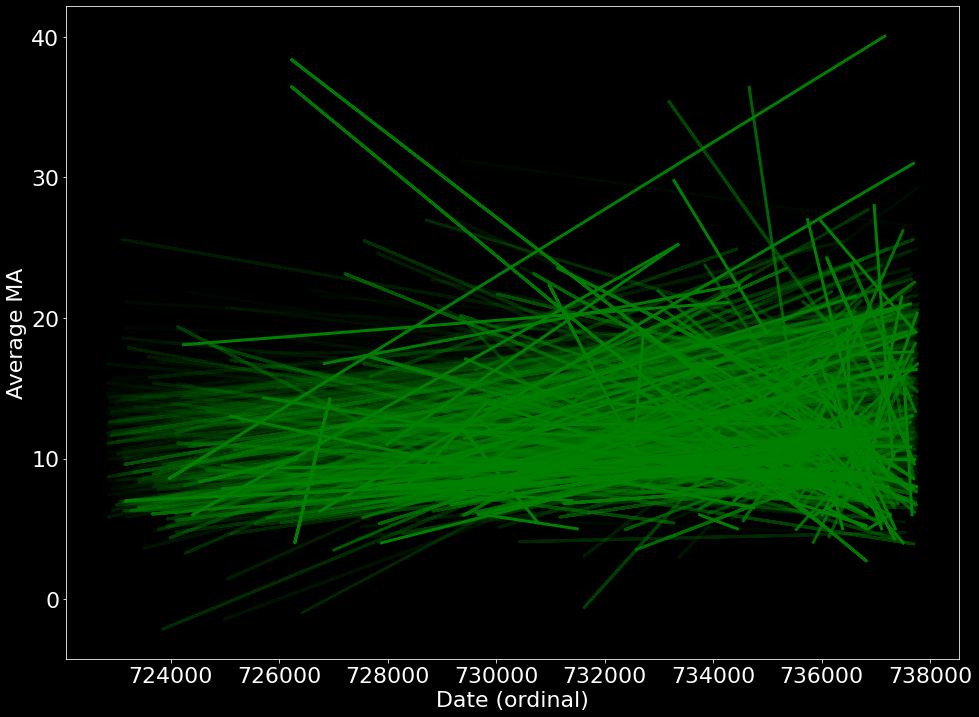

In [9]:
plt.figure(figsize=(16,12))

linear_regressor = LinearRegression()

class_sizes = []
class_rsqs = []
class_deltaMAs = []
class_slopes = []


for c in tqdm(list(results_df["filtered_classification"].unique())):
    sub_df = results_df[results_df["filtered_classification"] == c]
    if len(sub_df) > 10:

        class_sizes.append(len(sub_df))
    
        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            #Store slope
            class_slopes.append(reg.coef_[0][0])

            #Calculate deltaMA (change in MA of linear regression)
            class_deltaMAs.append(max(Y_pred)[0] - min(Y_pred)[0])

            # #Find r2, use that as alpha (just as a test)
            # X2 = sm.add_constant(X)
            # est = sm.OLS(Y, X2)
            # est2 = est.fit()
            
            # r2 = list(est2.summary2().tables[0][1])[-1]
            r2 = reg.score(X, Y)
            
            class_rsqs.append(r2)

            plt.plot(X, Y_pred, linewidth=3, alpha=float(r2), color="green")
        except ValueError as e:
            pass

# plt.legend()
plt.xlabel("Date (ordinal)")
plt.ylabel("Average MA")

# plt.savefig("assignee_author_linear_regressions.png", format="png")


100%|██████████| 1582/1582 [01:06<00:00, 23.89it/s]


Text(0, 0.5, 'Count')

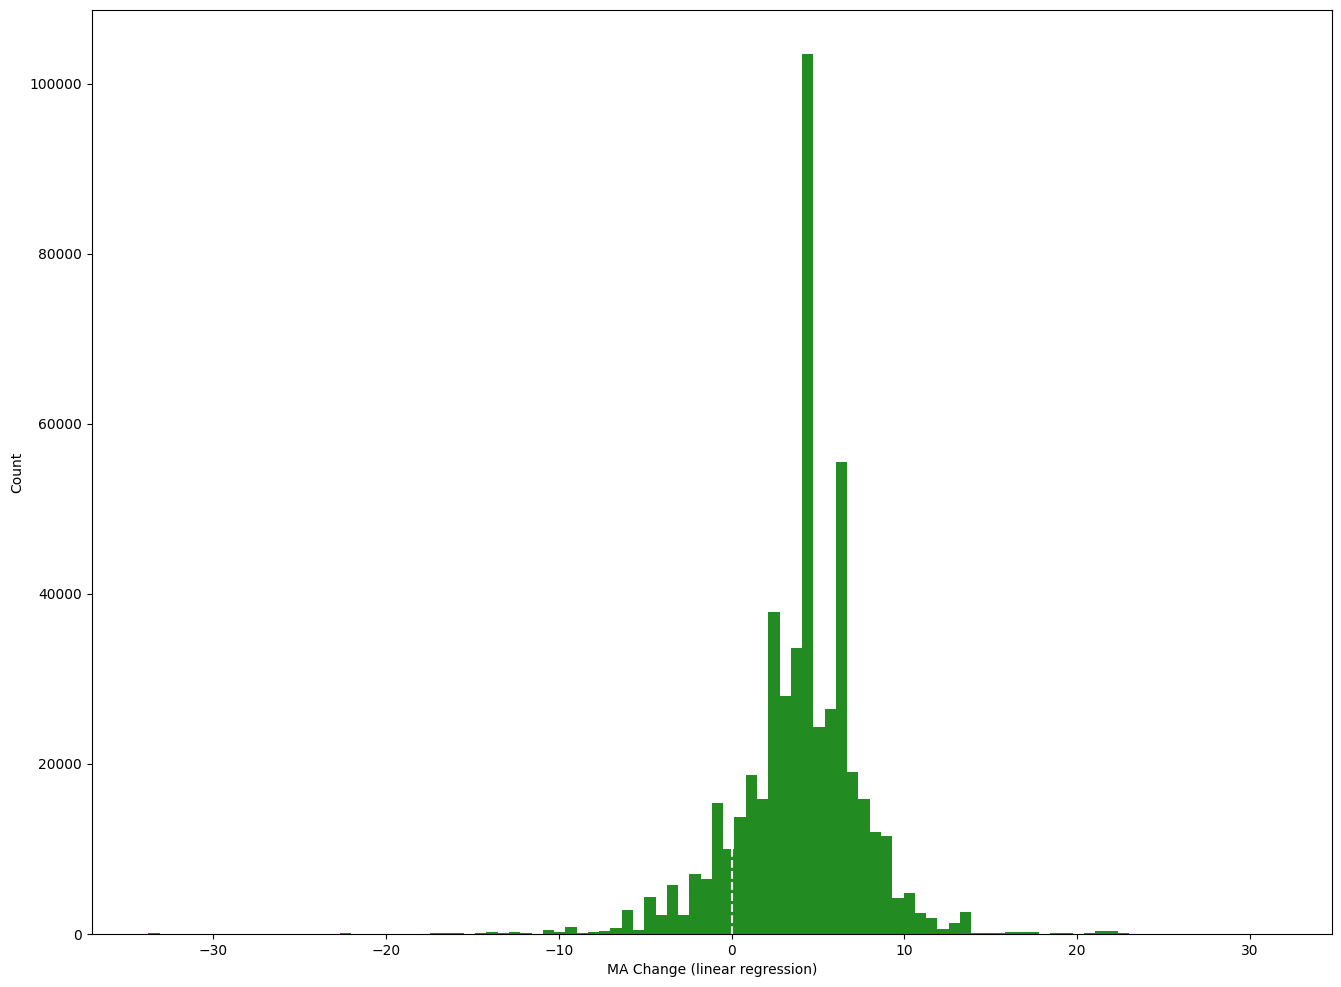

In [37]:
#Alternative graphing (finding slope change in MA)
linear_regressor = LinearRegression()

MA_slopes = []

for c in tqdm(list(results_df["filtered_classification"].unique())):
    sub_df = results_df[results_df["filtered_classification"] == c]
    if len(sub_df) > 10:

        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            #Calculate deltaMA (change in MA of linear regression, taking into consideration negative slopes)
            MA_slopes.extend([reg.coef_[0][0] * (max(X) - min(X))[0]]*len(sub_df))
                        
        except ValueError as e:
            pass

plt.figure(figsize=(16,12))


plt.hist(MA_slopes, bins=100, color="forestgreen")
plt.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--")
plt.xlabel("MA Change (linear regression)")
plt.ylabel("Count")


In [55]:
#Alternative graphing (finding slope change in MA)
linear_regressor = LinearRegression()

class_sizes = []
class_rsqs = []
class_deltaMAs = []

for c in tqdm(list(results_df["filtered_classification"].unique())):
    sub_df = results_df[results_df["filtered_classification"] == c]
    if len(sub_df) > 10:

        class_sizes.append(len(sub_df))
    
        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            #Calculate deltaMA (change in MA of linear regression, taking into consideration negative slopes)
            class_deltaMAs.append(reg.coef_[0][0] * (max(X) - min(X))[0])
            
            # r2 = list(est2.summary2().tables[0][1])[-1]
            class_rsqs.append(reg.score(X, Y))
                        
        except ValueError as e:
            pass



100%|██████████| 1582/1582 [01:06<00:00, 23.64it/s]


Text(0, 0.5, 'Average MA change')

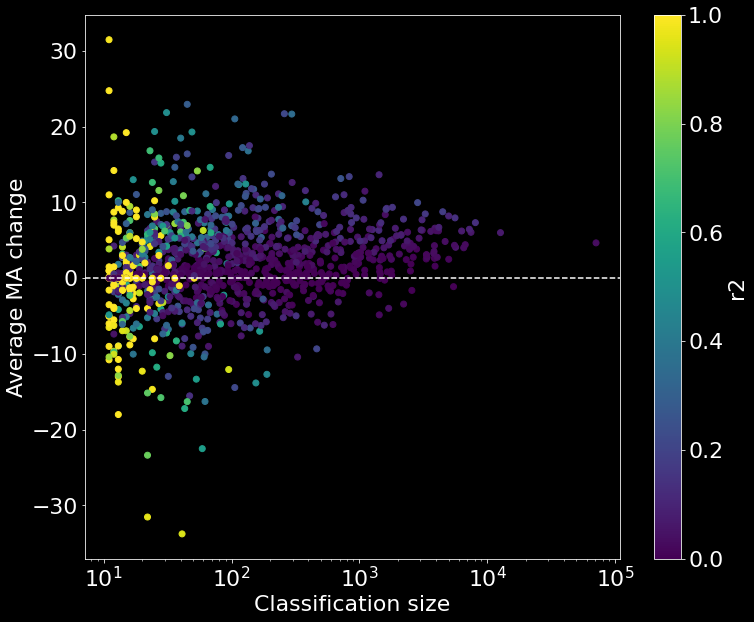

In [64]:
plt.subplots(figsize=(12,10))

sc = plt.scatter(class_sizes, class_deltaMAs, c = class_rsqs, cmap="viridis")
plt.colorbar(sc, label="r2")

plt.axhline(y=0, xmin=0, xmax=10e5, linestyle="--", color="white")

plt.xscale("log")

plt.xlabel("Classification size")
plt.ylabel("Average MA change")


In [10]:
# Now classes
correlation_loc = np.where(np.asarray(class_rsqs) >= 0.25)
print(correlation_loc)

class_deltaMAs_sig = [class_deltaMAs[i] for i in correlation_loc[0]]
class_slopes_sig = [class_slopes[i] for i in correlation_loc[0]]
class_rsqs_sig = [class_rsqs[i] for i in correlation_loc[0]]
class_sizes_sig = [class_sizes[i] for i in correlation_loc[0]]

print("Number of highly correlated values:", len(correlation_loc[0]))
print("Number of assignees:", len(class_rsqs))

(array([  11,   36,   40,   48,   57,   99,  104,  105,  107,  116,  119,
        149,  160,  163,  174,  177,  216,  255,  256,  278,  279,  281,
        283,  284,  289,  297,  300,  301,  311,  321,  322,  340,  369,
        370,  375,  384,  388,  390,  391,  396,  405,  406,  418,  419,
        426,  434,  440,  448,  461,  463,  464,  466,  469,  470,  471,
        472,  474,  477,  486,  489,  504,  519,  521,  525,  526,  528,
        530,  536,  537,  538,  543,  546,  547,  551,  553,  556,  560,
        562,  568,  569,  576,  579,  583,  584,  585,  587,  588,  596,
        598,  599,  602,  603,  605,  606,  611,  612,  619,  620,  621,
        626,  631,  633,  636,  642,  644,  651,  652,  653,  662,  665,
        667,  671,  682,  687,  692,  696,  697,  698,  699,  700,  701,
        703,  705,  707,  708,  713,  714,  716,  718,  719,  726,  729,
        734,  736,  739,  742,  744,  751,  752,  754,  755,  756,  760,
        761,  764,  766,  767,  768,  769,  771,  

Text(0.5, 0.98, 'Class Correlations - Average MA')

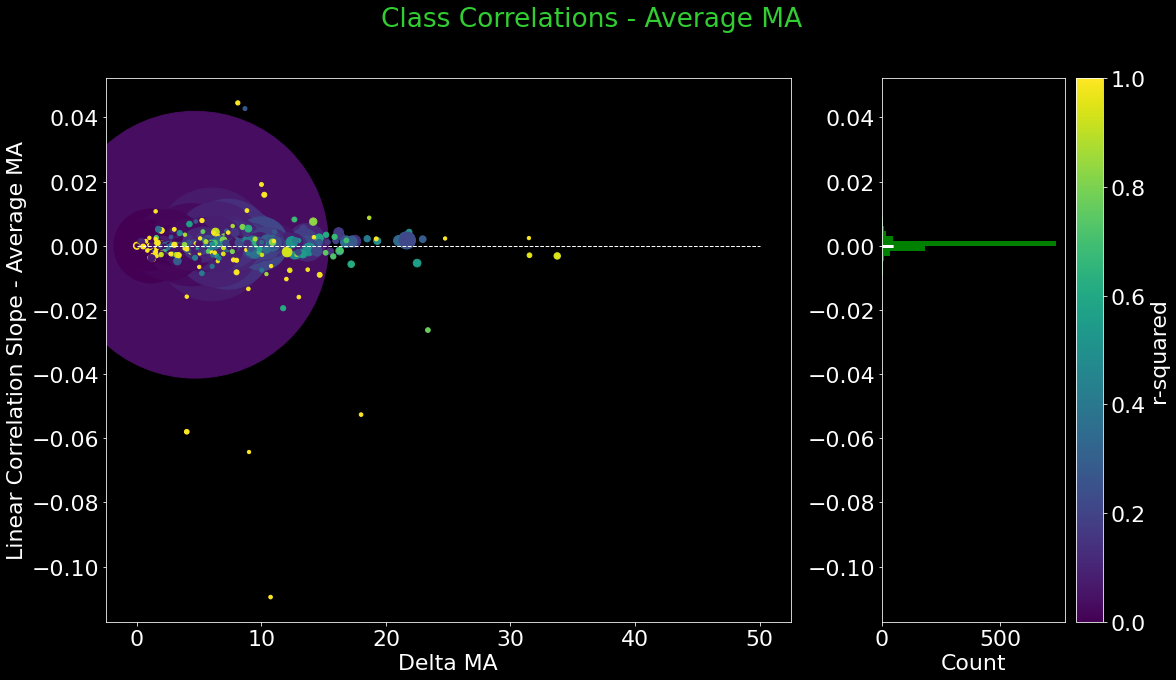

In [11]:
## Plot deltaMA / slope correlation (does deltaMA correspond with the slope at all? This is the big one...)
import matplotlib.colors as Color

#Authors first
fig, axes = plt.subplots(1,2, figsize=(18,10), gridspec_kw={"width_ratios":[3,1]})

scatter = axes[0].scatter(class_deltaMAs, class_slopes, c = class_rsqs, s=np.array(class_sizes), cmap="viridis")
axes[0].hlines(xmin=0,xmax=50, y=0, color="white", linewidth=1, linestyle="--")
axes[0].set_xlabel("Delta MA")
axes[0].set_ylabel("Linear Correlation Slope - Average MA")

axes[1].hist(class_slopes, bins=100, color="green", orientation="horizontal")
axes[1].hlines(xmin=0,xmax=50, y=0, color="white", linewidth=3, linestyle="--")
axes[1].set_xlabel("Count")


plt.colorbar(scatter, label="r-squared", ax=axes[1])

plt.suptitle("Class Correlations - Average MA", color="limegreen")

Text(0.5, 0.98, 'Class Correlations - Average MA, r2 >= 0.25')

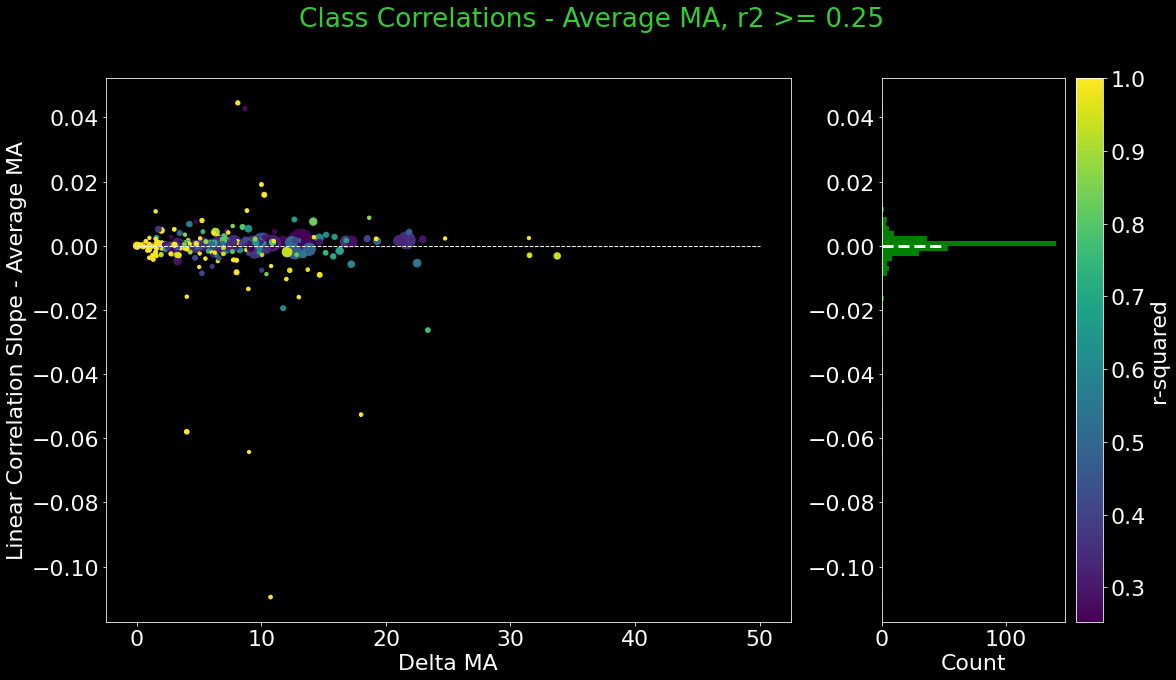

In [12]:
## Plot deltaMA / slope correlation (does deltaMA correspond with the slope at all? This is the big one...)
import matplotlib.colors as Color

#Authors first
fig, axes = plt.subplots(1,2, figsize=(18,10), gridspec_kw={"width_ratios":[3,1]})

scatter = axes[0].scatter(class_deltaMAs_sig, class_slopes_sig, c = class_rsqs_sig, s=np.array(class_sizes_sig), cmap="viridis")
axes[0].hlines(xmin=0,xmax=50, y=0, color="white", linewidth=1, linestyle="--")
axes[0].set_xlabel("Delta MA")
axes[0].set_ylabel("Linear Correlation Slope - Average MA")

axes[1].hist(class_slopes_sig, bins=100, color="green", orientation="horizontal")
axes[1].hlines(xmin=0,xmax=50, y=0, color="white", linewidth=3, linestyle="--")
axes[1].set_xlabel("Count")


plt.colorbar(scatter, label="r-squared", ax=axes[1])

plt.suptitle("Class Correlations - Average MA, r2 >= 0.25", color="limegreen")


Things to test for classifications:

- Size & delta MAs (find 10 largest, graph MA changes over time)
- Strongest correlation (find 10 strongest r2s)
- Most positive / negative (with/without strong correlation)

In [13]:
### Size & deltaMA

# Find 10 largest classifications
classifications_size_df = results_df.groupby("filtered_classification").size().sort_values(ascending=False)

print("----- Top 10 -----\n", classifications_size_df[0:10])
print()
print("----- 10 - 20 -----\n", classifications_size_df[10:20])


----- Top 10 -----
 filtered_classification
A61K31     71173
C07D401    12721
C07D213     8095
C07D413     7479
C07D405     7261
A61P25      6743
C07D417     6558
C07D403     6319
A01N43      5671
C07D471     5607
dtype: int64

----- 10 - 20 -----
 filtered_classification
A61P9      5554
C08K5      5460
G03F7      5007
C07D409    5000
C07D211    4692
C07D239    4495
C07D487    4188
A61K38     4162
A61K8      4071
A61K9      3996
dtype: int64


Slope: 0.0003115389276484657
Slope (in MA values): 4.662491591186937
r2: 0.03502162712627577


Text(0, 0.5, 'Avg MA')

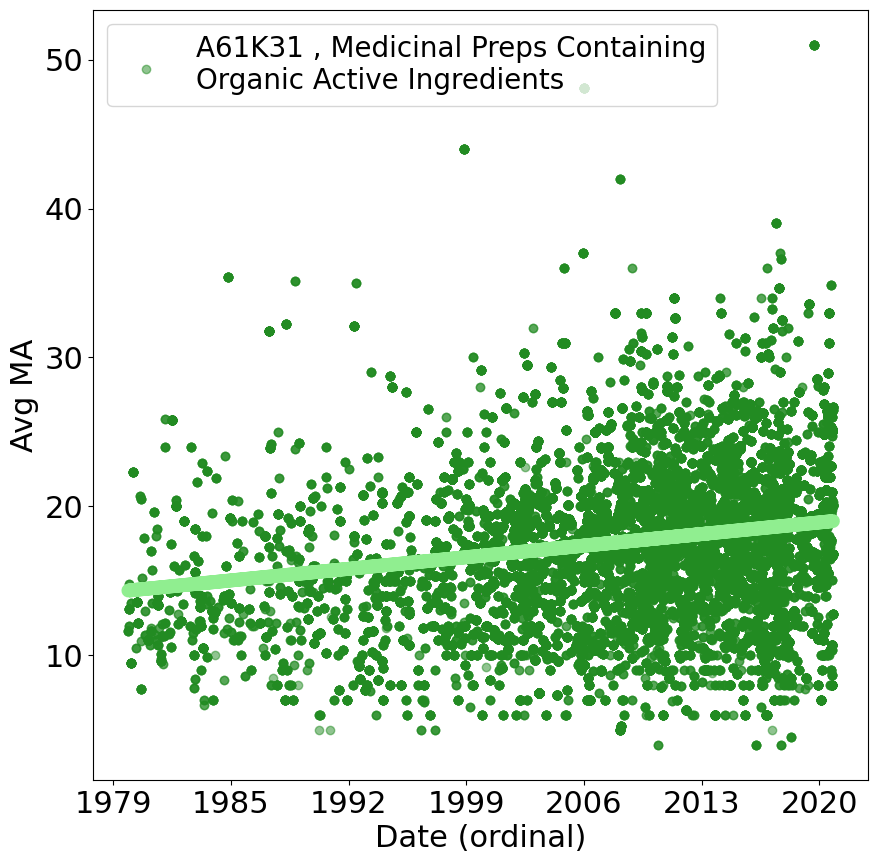

In [96]:
### Graphing for largest 5 classes (>7k compounds)
plt.subplots(figsize=(10,10))

plt.rcParams.update({'font.size': 22})

classes = ["A61K31", "C07D401", "C07D213", "C07D413", "C07D405"]

for c in classes[0:1]:
    sub_df = results_df[results_df["filtered_classification"] == c]

    plt.scatter(x = list(sub_df["date_ordinal"]), y = list(sub_df["MA_avg"]), 
                label=c + " , Medicinal Preps Containing\nOrganic Active Ingredients", alpha=0.5, color="forestgreen")
    # sns.jointplot(x = list(sub_df["date_ordinal"]), y = list(sub_df["MA_avg"]), label=c, alpha=0.5, height=10)
    # sns.regplot(x = list(sub_df["date_ordinal"]), y = list(sub_df["MA_avg"]))

    X = sub_df["date_ordinal"].values.reshape(-1,1)
    Y = sub_df["MA_avg"].values.reshape(-1,1)
       
    reg = linear_regressor.fit(X, Y)

    print("Slope:", reg.coef_[0][0])
    print("Slope (in MA values):", (reg.coef_[0][0] * (max(X) - min(X)))[0])
    print("r2:", reg.score(X, Y))
    Y_pred = linear_regressor.predict(X)

    plt.plot(X, Y_pred, linewidth=10, color="lightgreen")

plt.legend(prop={"size":20})
plt.xlabel("Date (ordinal)")
ticks = [722500, 725000, 727500, 730000, 732500, 735000, 737500]
plt.xticks(ticks = ticks, labels = [date.datetime.fromordinal(d).year for d in ticks])
plt.ylabel("Avg MA")

No handles with labels found to put in legend.


Text(564.2857142857143, 0.5, 'Avg MA')

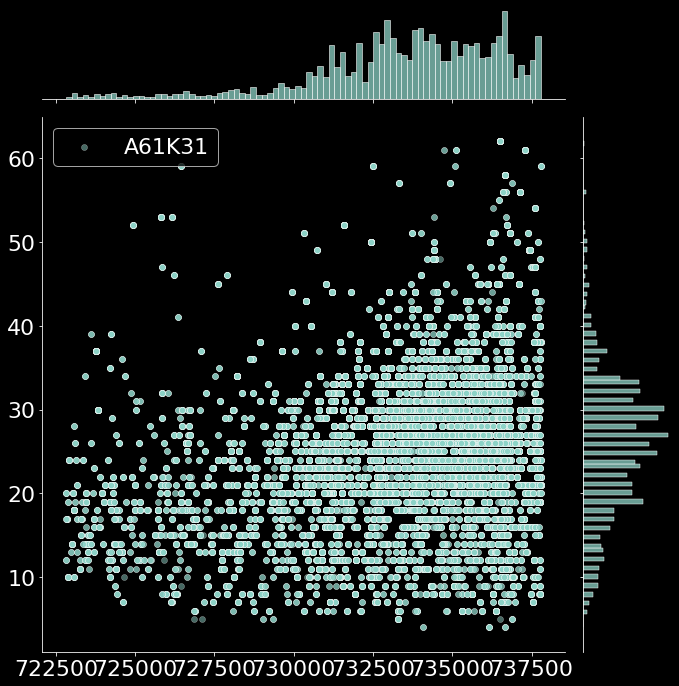

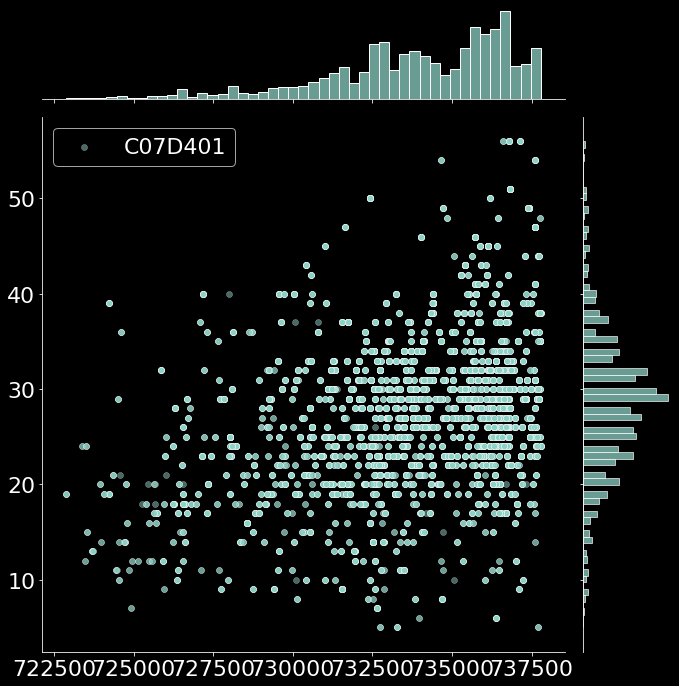

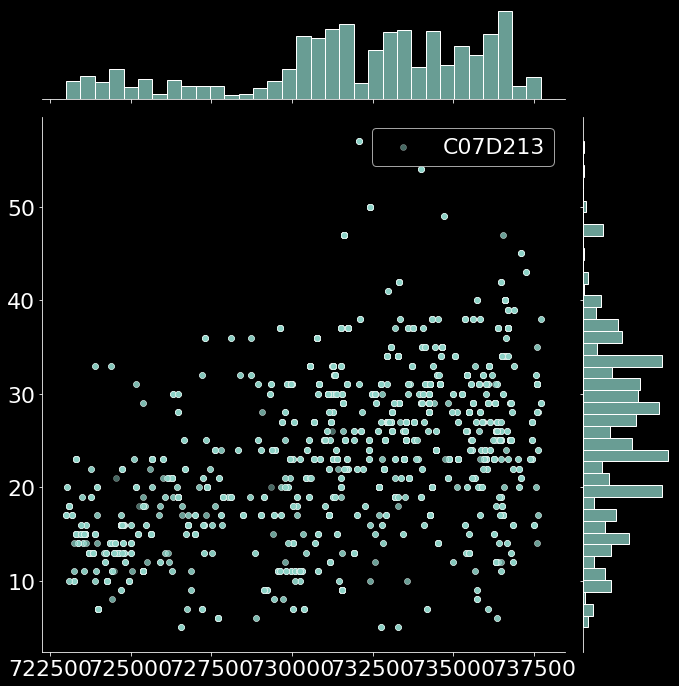

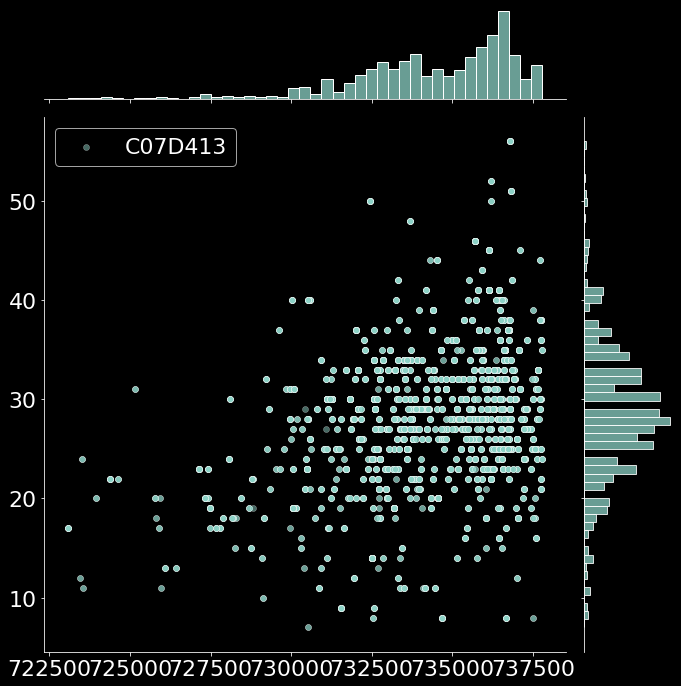

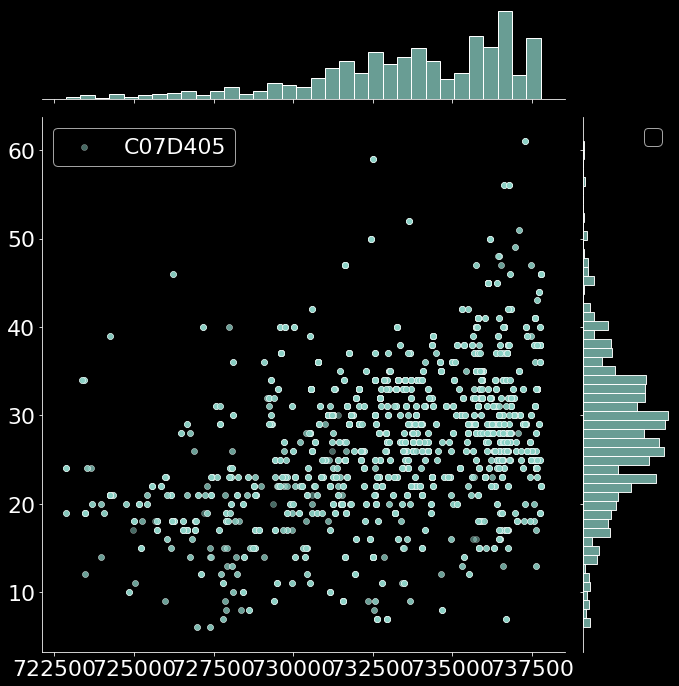

In [27]:
### Graphing for largest 5 classes (>7k compounds)

classes = ["A61K31", "C07D401", "C07D213", "C07D413", "C07D405"]

for c in classes:
    sub_df = results_df[results_df["filtered_classification"] == c]
    sns.jointplot(x = list(sub_df["date_ordinal"]), y = list(sub_df["MA_max"]), label=c, alpha=0.5, height=10)


plt.legend()
plt.xlabel("Date (ordinal)")
plt.ylabel("Max MA")

## Novel Cpd MA increase

How often are novel compounds found in authors/assignee patents - and do their MAs increase

In [ ]:
### Testing: what do novel cpd ids look like

newIDs = pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/CpdPatentIdsDates/New_Ids/newIds_1980-02.p", "rb"))
print(newIDs)

Data structure: dictionary with month:[newIDs] 

In [58]:
newIDs = {}
for month in tqdm(build_month_increments(1980,2019)[1:]):
    newIDs[dt.datetime.strptime(month, "%Y-%m")] = pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/CpdPatentIdsDates/New_Ids/newIds_" + month + ".p", "rb"))

100%|██████████| 479/479 [00:06<00:00, 74.65it/s] 


In [57]:
date = dt.datetime.strptime("1980-02", "%Y-%m")
print(date)
print(date.month)

1980-02-01 00:00:00
2


Goal - for each patent, find all new ids 

Pseudocode
- find all IDs for each patent
- find the novel IDs generated within the _month_ when the patent was registerd
- novel IDs per patent = difference (patent IDs, all novel IDs)
- find the count per patent
- also find average MA of novel cpds (because why not)

In [245]:
def get_novel_IDs(id, date, newIDs, patent_cpd_links):
    """ Finds the novel ids generated in a specific month that are found in a specific patent

    Args:
        id (str): Patent ID to search for
        date (datetime object): Date of patent registration
        newIDs (dict): {month: [novel IDs]}
        patent_cpd_links (dict): {patent ID: SureChemBL ids}

    Returns:
        list: list of all novel compounds within a specific patent
    """
    novel_ids = []

    #Find novel ids given a month/date of a patent
    for key in newIDs.keys():
        if key.year == date.year and key.month == date.month:
            novel_ids = set(newIDs[key])

    #Find patent IDs which are also in novel ids
    return list((set(novel_ids) & set(patent_cpd_links[id])))
    
    

In [246]:
## Step 1: all IDs
patent_novelID_links = {}
id_date = dict(zip(results_df["ID"], results_df["date"]))

In [247]:
## Step 2 & 3: novel Ids per patent

novel_ids = {}

for id, date in tqdm(id_date.items()):
    novel_ids[id] = get_novel_IDs(id, date, newIDs, patent_cpd_links)


100%|██████████| 11867/11867 [01:21<00:00, 144.87it/s]


In [77]:
print(list(novel_ids.items())[0:1])

[('US-8440663-B2', ['SCHEMBL4382248', 'SCHEMBL8086781', 'SCHEMBL4376933', 'SCHEMBL4377185', 'SCHEMBL13588471'])]


In [248]:
novelIDs_MA_links = {}

for patent, ids in tqdm(novel_ids.items()):
    novelIDs_MA_links[patent] = get_MA_values(ids, cpd_MA_links)

print(list(novelIDs_MA_links.items())[0:2])

100%|██████████| 11867/11867 [00:00<00:00, 207704.14it/s]

[('US-8440663-B2', [15.0, 28.0, 25.0]), ('US-8012956-B2', [14.0])]


In [249]:
#Get number of novel ids per patent
novelIDs_count_links = {}

for patent, ids in tqdm(novel_ids.items()):
    novelIDs_count_links[patent] = len(ids)

100%|██████████| 11867/11867 [00:00<00:00, 873086.80it/s]


In [250]:
results_df["novel_MAs"] = results_df["ID"].map(novelIDs_MA_links)

In [251]:
## Add avg MA to results_df
MA_avgs = results_df.explode("novel_MAs").groupby("ID").novel_MAs.apply(np.mean)
MA_maxes = results_df.explode("novel_MAs").groupby("ID").novel_MAs.apply(max)
MA_avgs = dict(MA_avgs)
MA_maxes = dict(MA_maxes)

results_df["novel_MA_avg"] = results_df["ID"].map(MA_avgs)
results_df["novel_MA_max"] = results_df["ID"].map(MA_maxes)
results_df["novel_ID_count"] = results_df["ID"].map(novelIDs_count_links)

print(results_df)

        Unnamed: 0              ID             author  \
169            929   US-8440663-B2          AAY NAING   
170            947   US-8440663-B2      ARCALAS ARLYN   
171            965   US-8440663-B2      BROWN S DAVID   
172            983   US-8440663-B2  CHAN WAI KI VICKY   
173           1001   US-8440663-B2          CHEN JEFF   
...            ...             ...                ...   
373699      907631   US-8309497-B1         ZHANG YING   
373732      907673  US-10619065-B2     ZHOU ZHANG-LIN   
373733      907675  US-10619030-B2     ZHOU ZHANG-LIN   
373737      907681   US-9751966-B2     ZWEIG ANDREW M   
373738      907682    US-4914171-A     ZWEIG ANDREW M   

                             assignees  \
169                       EXELIXIS_INC   
170                       EXELIXIS_INC   
171                       EXELIXIS_INC   
172                       EXELIXIS_INC   
173                       EXELIXIS_INC   
...                                ...   
373699     HALLIBURTO

In [252]:
novel_results_df = results_df.dropna()


In [254]:
print(novel_results_df)

        Unnamed: 0                ID             author             assignees  \
169            929     US-8440663-B2          AAY NAING          EXELIXIS_INC   
170            947     US-8440663-B2      ARCALAS ARLYN          EXELIXIS_INC   
171            965     US-8440663-B2      BROWN S DAVID          EXELIXIS_INC   
172            983     US-8440663-B2  CHAN WAI KI VICKY          EXELIXIS_INC   
173           1001     US-8440663-B2          CHEN JEFF          EXELIXIS_INC   
...            ...               ...                ...                   ...   
369772      902314  WO-2015046480-A1   TAKAHASHI TERUKI  SUMITOMO_CHEMICAL_CO   
373287      907108     US-9695167-B2       WU LIANGXING           INCYTE_CORP   
373288      907110     US-9695167-B2      Wang xiaozhao           INCYTE_CORP   
373289      907112     US-9695167-B2        YAO WENQING           INCYTE_CORP   
373290      907114     US-9695167-B2        ZHANG COLIN           INCYTE_CORP   

                           

100%|██████████| 135/135 [00:00<00:00, 243.47it/s]


Text(0, 0.5, 'MA')

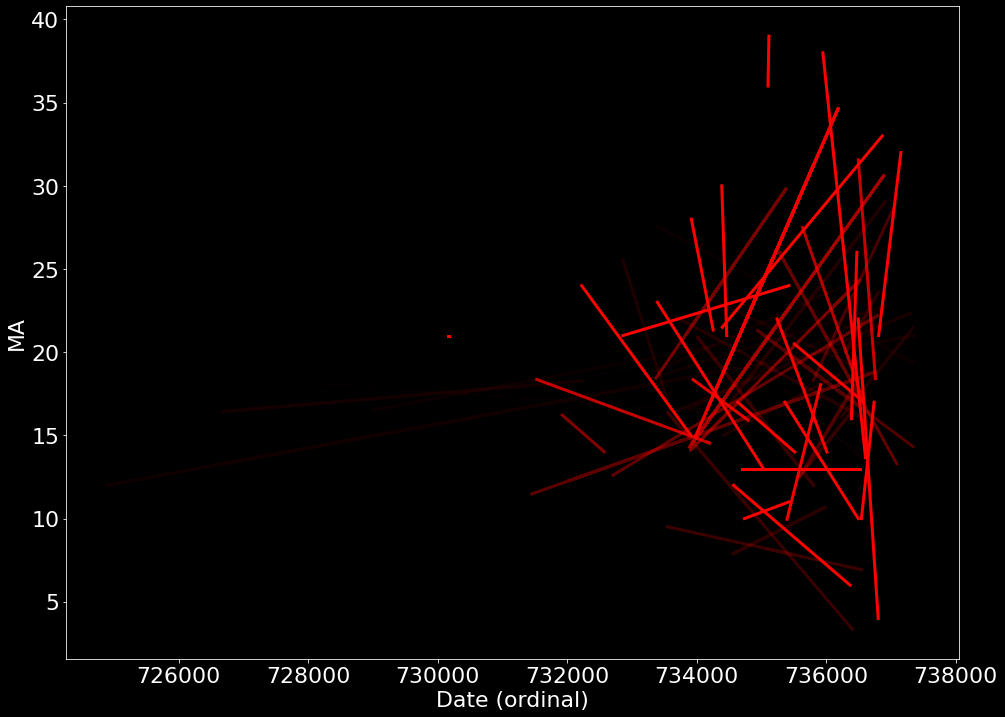

In [95]:
plt.figure(figsize=(16,12))

linear_regressor = LinearRegression()

assignee_sizes = []
assignee_rsqs = []
assignee_deltaMAs = []
assignee_slopes = []

for assignee in tqdm(list(novel_results_df["assignees"].unique())):
    sub_df = results_df[novel_results_df["assignees"] == assignee]
    assignee_sizes.append(len(sub_df))

    if len(sub_df) > 8:
    
        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["novel_MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            #Store slope
            assignee_slopes.append(reg.coef_[0][0])

            #Calculate deltaMA (change in MA of linear regression)
            assignee_deltaMAs.append(max(Y_pred)[0] - min(Y_pred)[0])

            #Find r2, use that as alpha (just as a test)
            X2 = sm.add_constant(X)
            est = sm.OLS(Y, X2)
            est2 = est.fit()
            
            r2 = reg.score(X, Y)
            assignee_rsqs.append(r2)

            plt.plot(X, Y_pred, linewidth=3, alpha=float(r2), color="red")
        except ValueError as e:
            pass



# plt.legend()
plt.xlabel("Date (ordinal)")
plt.ylabel("MA")

Text(0, 0.5, 'Linear Correlation Slope')

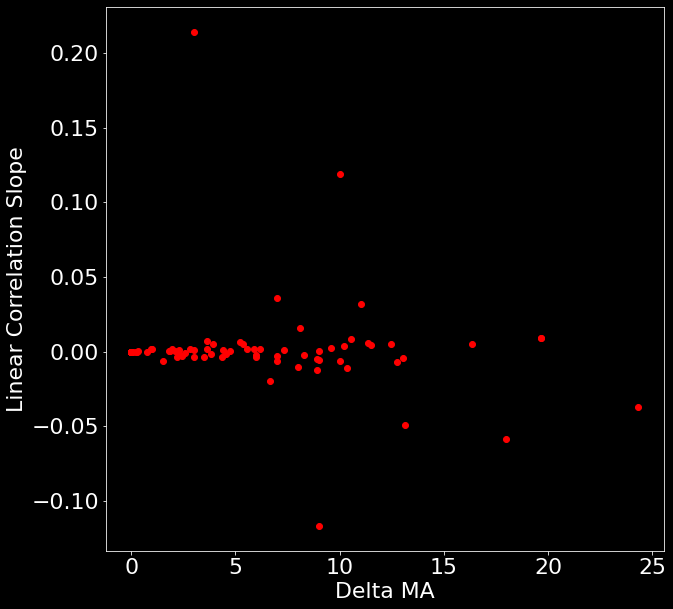

In [102]:
#Now assignees
plt.figure(figsize=(10,10))

plt.scatter(assignee_deltaMAs, assignee_slopes, color="red")

plt.xlabel("Delta MA")
plt.ylabel("Linear Correlation Slope")

Text(0, 0.5, 'Novel Compounds Per Patent')

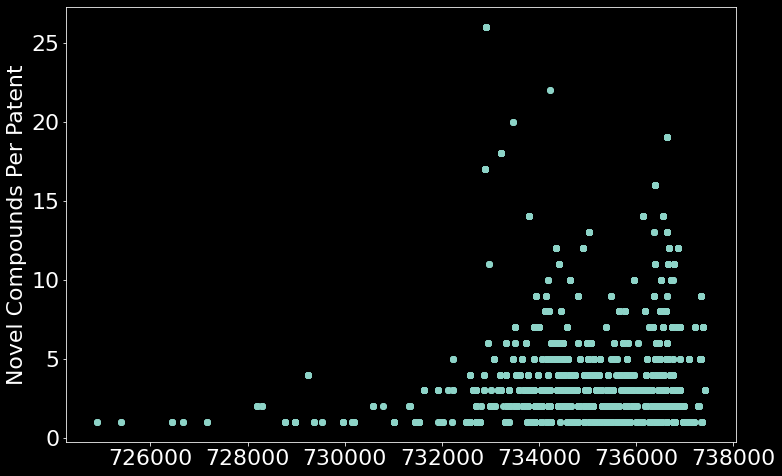

In [260]:
#Novel cpd count by time

plt.figure(figsize=(12,8))

plt.scatter(novel_results_df["date_ordinal"], novel_results_df["novel_ID_count"])

plt.ylabel("Novel Compounds Per Patent")

Text(0, 0.5, 'Average Novel MA Per Patent')

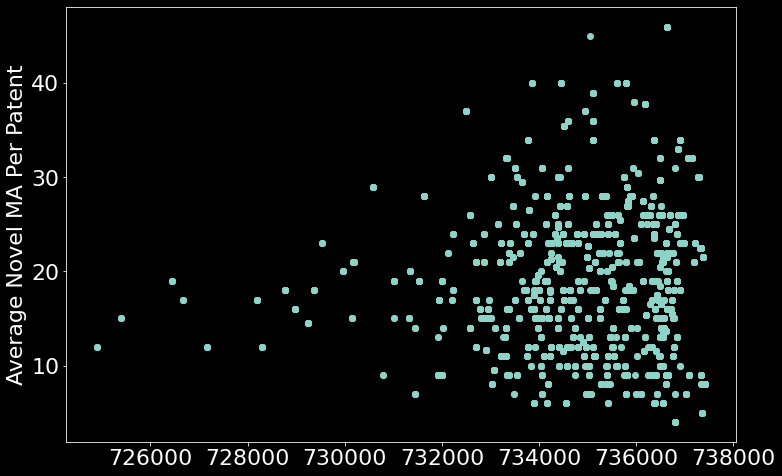

In [259]:
#Novel cpd average by time

plt.figure(figsize=(12,8))

plt.scatter(novel_results_df["date_ordinal"], novel_results_df["novel_MA_avg"])

plt.ylabel("Average Novel MA Per Patent")

Text(0, 0.5, 'Max Novel MA Per Patent')

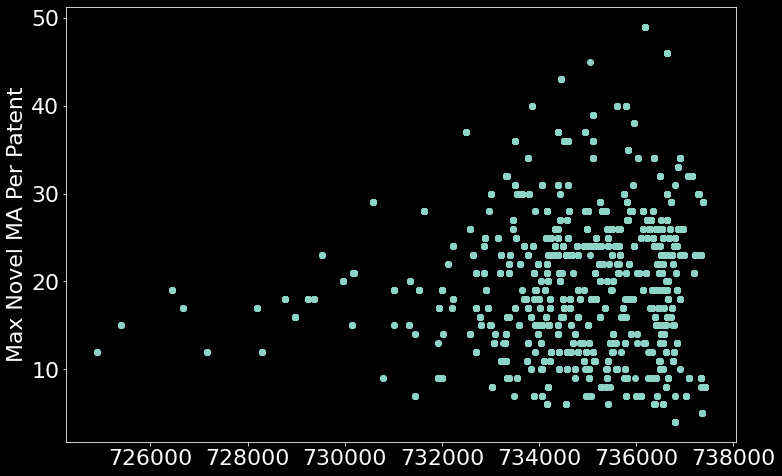

In [261]:
#Novel cpd max by time

plt.figure(figsize=(12,8))

plt.scatter(novel_results_df["date_ordinal"], novel_results_df["novel_MA_max"])

plt.ylabel("Max Novel MA Per Patent")